# Rapport final - Analyse des incidents liés à la police aux États-Unis d'Amérique
> Mohamedlamine Amimi <mohamedlamine.amimi@supinfo.com>
> Théo Bezin <theo.bezin@supinfo.com>
> Alexis Lecomte <alexis.lecomte@supinfo.com>
> Maxence Pawlowski <maxence.pawlowski@supinfo.com>

In [3]:
# Calculs mathématiques
import math
import numpy

# Chargement et prise en charge des données
import pandas

# Prise en charge des données géographique
import geopandas
import folium
from folium import plugins

# Création de statistiques et de graphiques
import scipy.stats
import matplotlib.pyplot as pyplot
from matplotlib.ticker import NullFormatter
import plotly.express as px

# Autres
import os
import re
import time
from datetime import datetime
from tabulate import tabulate
import webbrowser
from colorama import Fore, Style

%matplotlib notebook
pyplot.style.use("ggplot")
pyplot.rcParams["figure.figsize"] = [17, 7]
pyplot.rcParams["figure.max_open_warning"] = 30

## Analyse de "WashingtonPostDatabase.csv"

In [2]:
data_wp = pandas.read_csv("../data/WahsingtonPostDatabase.csv", parse_dates=["date"], date_parser=pandas.to_datetime)
data_wp.dtypes

id                                  int64
name                               object
date                       datetime64[ns]
manner_of_death                    object
armed                              object
age                               float64
gender                             object
race                               object
city                               object
state                              object
signs_of_mental_illness              bool
threat_level                       object
flee                               object
body_camera                          bool
longitude                         float64
latitude                          float64
is_geocoding_exact                   bool
dtype: object

Nous vérifions la qualité du dataset.

In [3]:
data_wp.isna().sum()

id                            0
name                        353
date                          0
manner_of_death               0
armed                       209
age                         413
gender                        7
race                       1323
city                          0
state                         0
signs_of_mental_illness       0
threat_level                  0
flee                        653
body_camera                   0
longitude                   711
latitude                    711
is_geocoding_exact            0
dtype: int64

Nous nous débarrassons des données nulles.

In [4]:
data_wp["name"] = data_wp["name"].fillna("Unknown") 				# replace NaN  by unknown
data_wp["armed"] = data_wp["armed"].fillna("Unknown") 				# replace NaN  by unknown
data_wp["gender"] = data_wp["gender"].fillna("Unknown") 			# replace NaN  by unknown
data_wp["race"] = data_wp["race"].fillna("Unknown") 				# replace NaN  by unknown
data_wp["threat_level"] = data_wp["threat_level"].fillna("Unknown") # replace NaN  by unknown
data_wp["flee"] = data_wp["flee"].fillna("Unknown") 				# replace NaN  by unknown
data_wp["latitude"] = data_wp["latitude"].fillna("Unknown") 		# replace NaN  by unknown
data_wp["longitude"] = data_wp["longitude"].fillna(0) 				# replace NaN  by unknown
age_mean = data_wp["age"].mean()
data_wp["age"] = data_wp["age"].fillna(round(age_mean))  			# replace NaN age by mean

data_wp.head()

id                name       date   manner_of_death       armed   age  \
0   3          Tim Elliot 2015-01-02              shot         gun  53.0   
1   4    Lewis Lee Lembke 2015-01-02              shot         gun  47.0   
2   5  John Paul Quintero 2015-01-03  shot and Tasered     unarmed  23.0   
3   8     Matthew Hoffman 2015-01-04              shot  toy weapon  32.0   
4   9   Michael Rodriguez 2015-01-04              shot    nail gun  39.0   

  gender race           city state  signs_of_mental_illness threat_level  \
0      M    A        Shelton    WA                     True       attack   
1      M    W          Aloha    OR                    False       attack   
2      M    H        Wichita    KS                    False        other   
3      M    W  San Francisco    CA                     True       attack   
4      M    H          Evans    CO                    False       attack   

          flee  body_camera  longitude latitude  is_geocoding_exact  
0  Not fleeing        False   -123.122   47.247                True  
1  Not fleeing        False   -122.892   45.487                True  
2  Not fleeing        False    -97.281   37.695                True  
3  Not fleeing        False   -122.422   37.763                True  
4  Not fleeing        False   -104.692   40.384                True

Nous vérifions les cases vides de chaque colonne de données.

In [5]:
data_wp.isna().sum()

id                         0
name                       0
date                       0
manner_of_death            0
armed                      0
age                        0
gender                     0
race                       0
city                       0
state                      0
signs_of_mental_illness    0
threat_level               0
flee                       0
body_camera                0
longitude                  0
latitude                   0
is_geocoding_exact         0
dtype: int64

In [6]:
nb_data = data_wp.shape[1] * data_wp.shape[0]
nb_data

123624

In [7]:
data_wp.isna().sum().sum() / nb_data * 100

0.0

Nous avons 0 % de données manquantes après le nettoyage des données.

In [8]:
data_wp.duplicated().sum()

0

Aucune duplication dans le fichier.

### Skew - Médiane - Mode - Moyenne
Le coefficient d'asymétrie (pour la loi normale skew=0)

In [9]:
(data_wp.skew(numeric_only=True) - 0).sort_values()

is_geocoding_exact        -20.029178
id                         -0.015711
age                         0.758072
signs_of_mental_illness     1.376367
longitude                   1.561354
body_camera                 2.073920
dtype: float64

In [10]:
data_wp.age.median()  # the middle valuex c'est 36

36.0

In [11]:
data_wp.age.mode()  # the most repeated value est 37

0    37.0
Name: age, dtype: float64

In [12]:
data_wp.age.mean()  # the average value age 37 ans

37.12898789878988

<IPython.core.display.Javascript object>


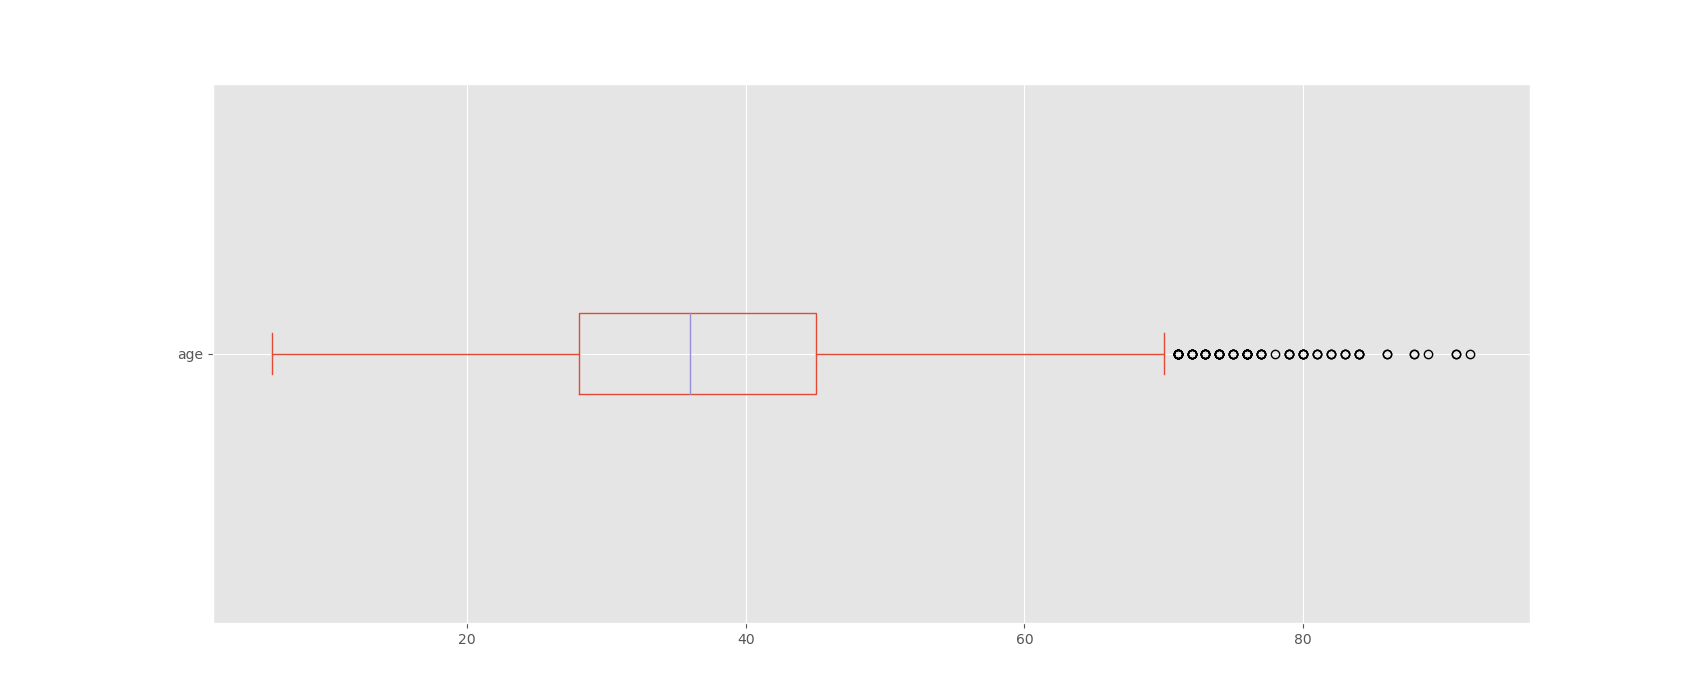

In [13]:
wp_age_fig, wp_age_ax = pyplot.subplots()
_ = data_wp.age.plot(ax=wp_age_ax, kind="box", vert=False)

In [14]:
data_wp.race.value_counts(normalize=True) * 100  # Transformation 41 % de W et 21% B attention au moins 18% ne sont pas connus

W          41.570407
B          21.933443
Unknown    18.193069
H          14.961496
A           1.443894
N           1.251375
O           0.646315
Name: race, dtype: float64

<IPython.core.display.Javascript object>


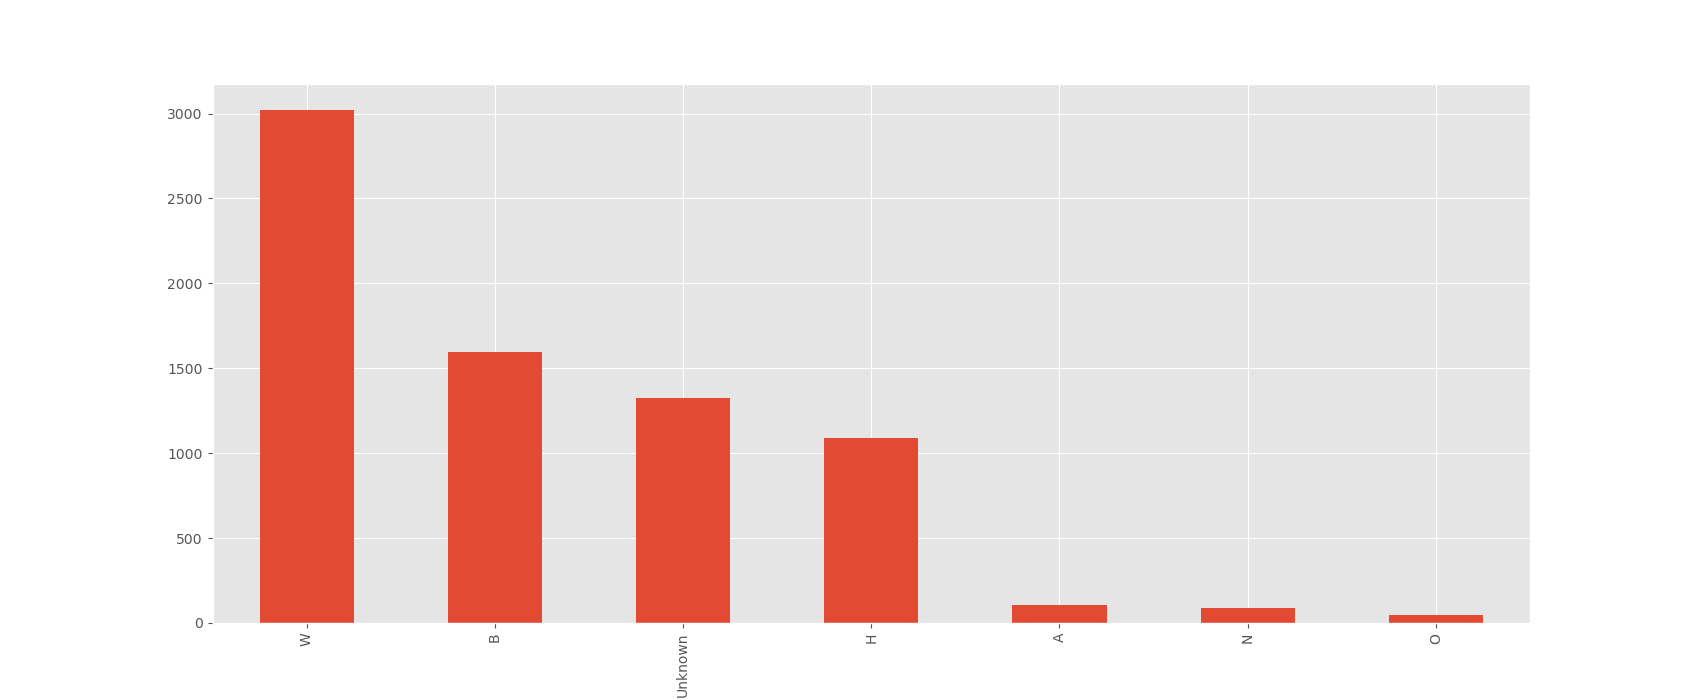

In [15]:
wp_race_fig, wp_race_ax = pyplot.subplots()
_ = data_wp.race.value_counts().plot(ax=wp_race_ax, kind="bar")

In [16]:
data_wp.gender.value_counts(normalize=True) * 100  # Transformation % 95% sont des hommes

M          95.393289
F           4.510451
Unknown     0.096260
Name: gender, dtype: float64

<IPython.core.display.Javascript object>


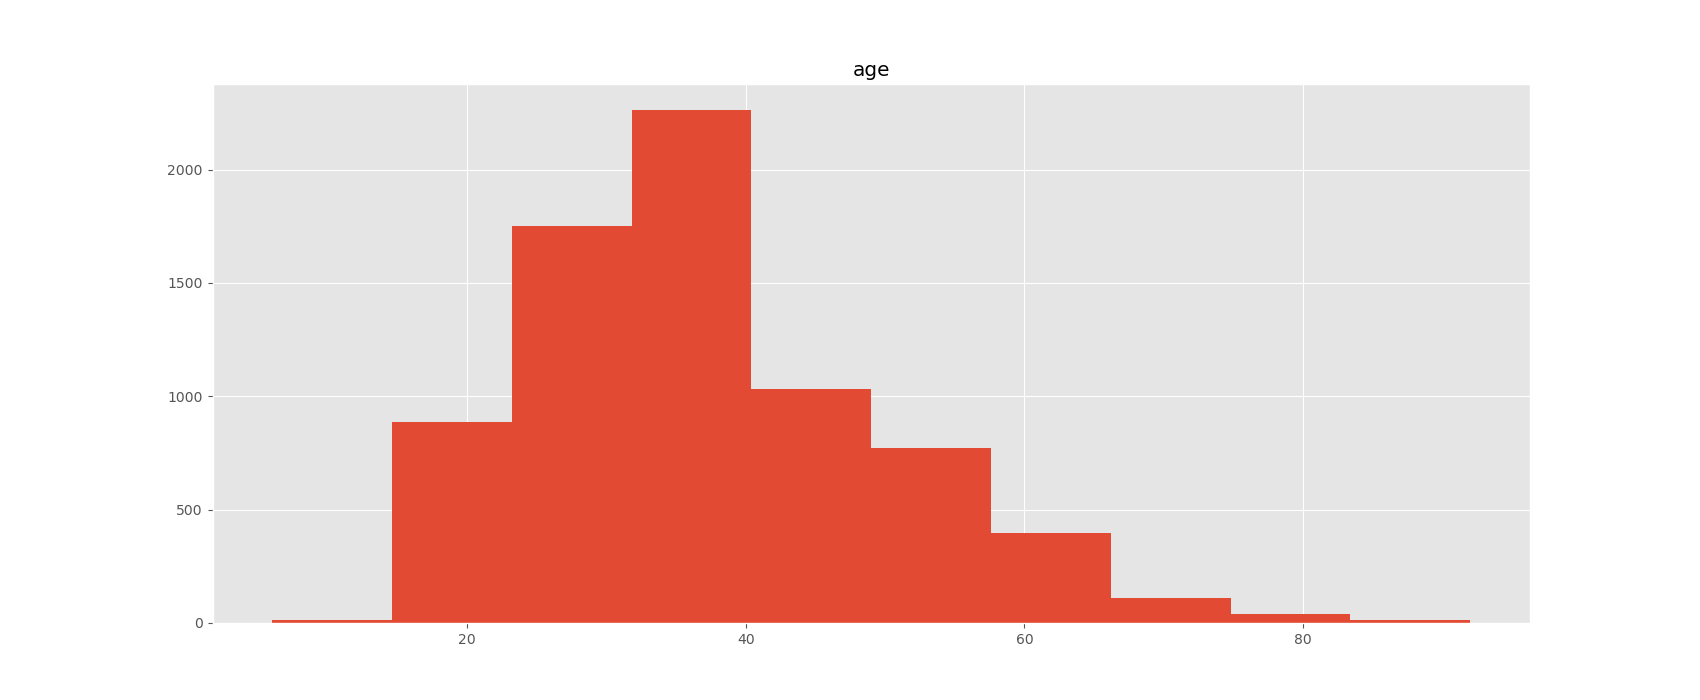

In [17]:
wp_age2_fig, wp_age2_ax = pyplot.subplots()
_ = data_wp.hist("age", ax=wp_age2_ax)

<IPython.core.display.Javascript object>


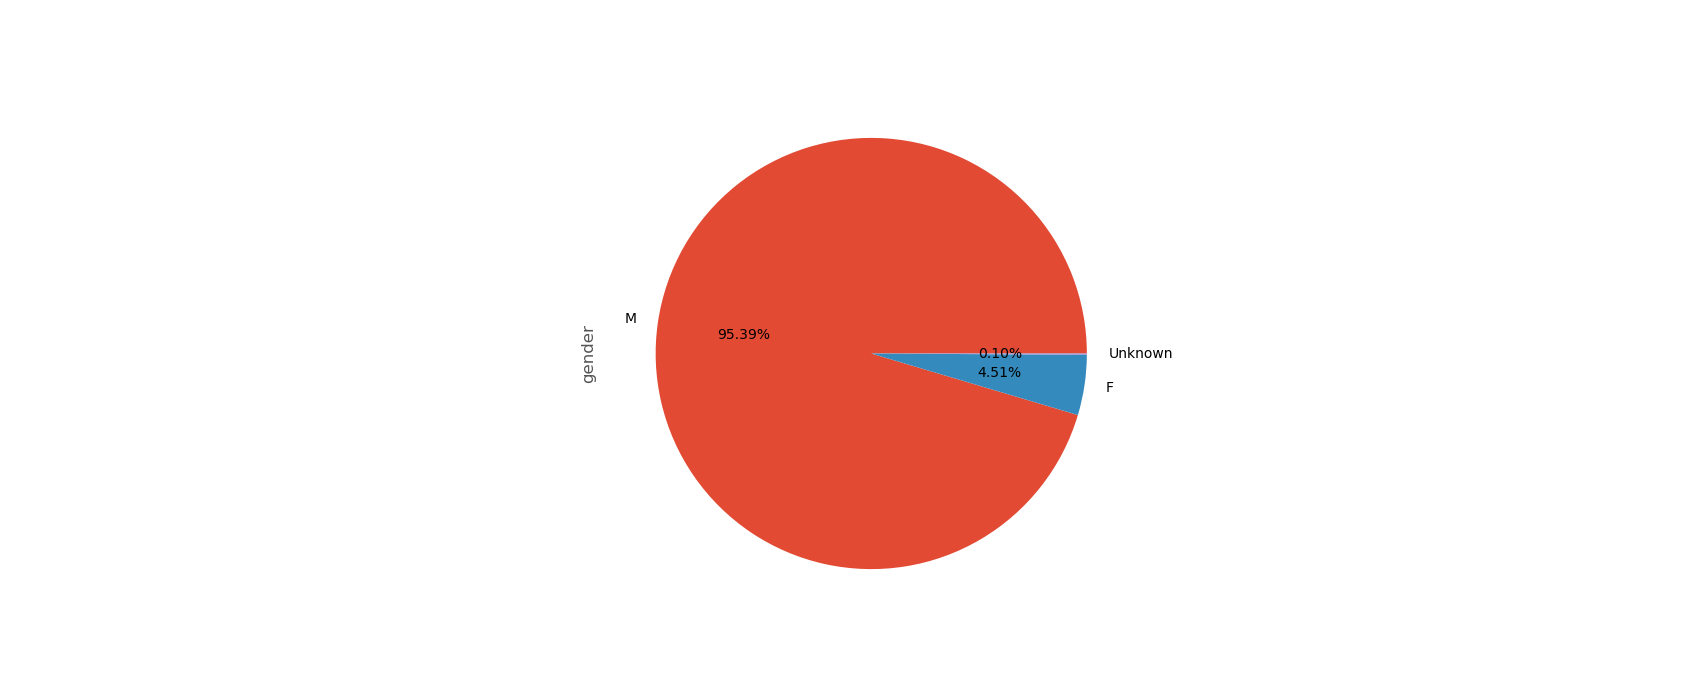

In [18]:
wp_gender_fig, wp_gender_ax = pyplot.subplots()
_ = data_wp.gender.value_counts().plot(ax=wp_gender_ax, kind="pie", autopct="%1.2f%%")

In [19]:
data_wp.flee.value_counts(normalize=True) * 100  # Transformation % plus de la moitié des arrestation se font sans tentative de fuite

Not fleeing    58.182068
Car            16.240374
Foot           12.953795
Unknown         8.979648
Other           3.644114
Name: flee, dtype: float64

<IPython.core.display.Javascript object>


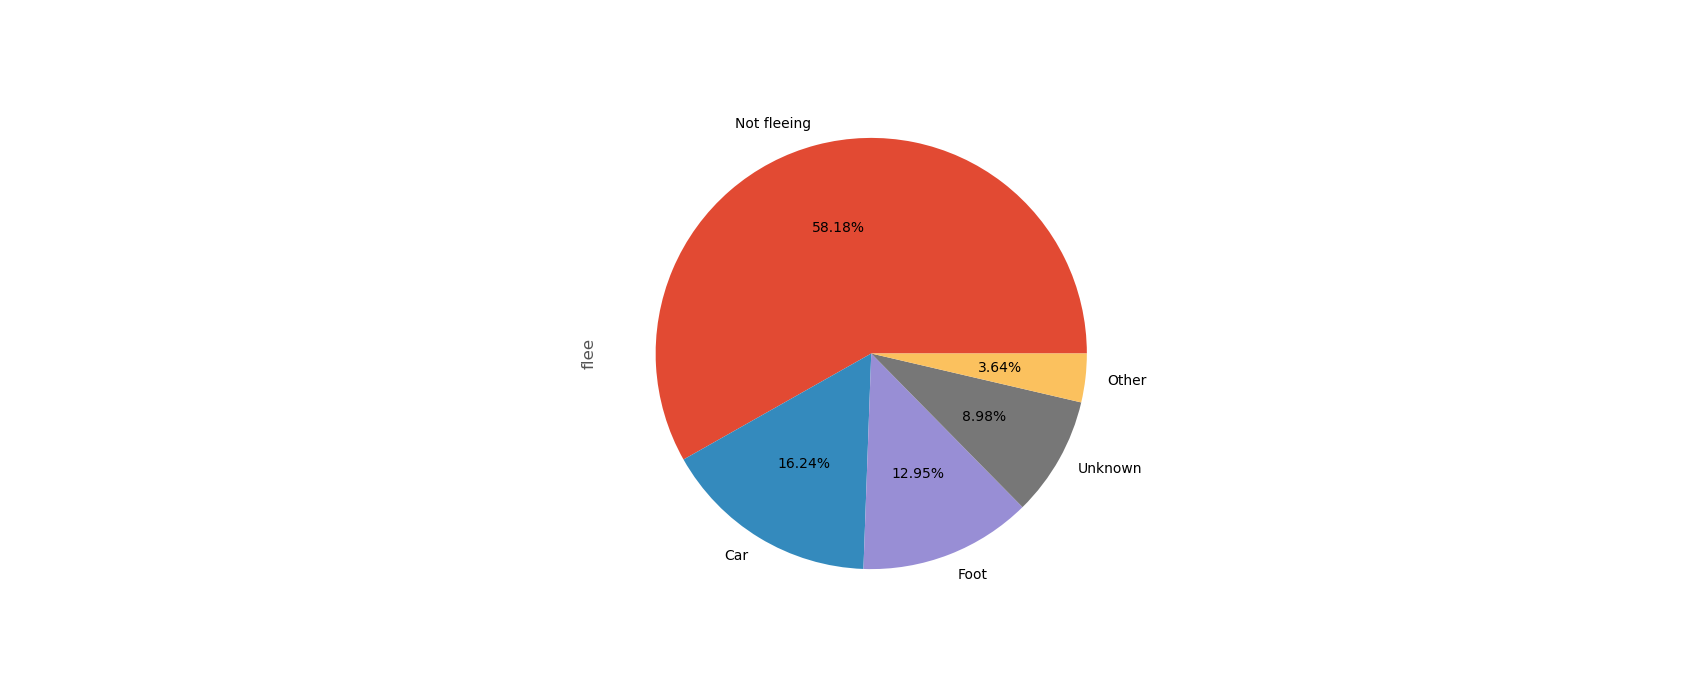

In [20]:
wp_flee_fig, wp_flee_ax = pyplot.subplots()
_ = data_wp.flee.value_counts().plot(ax=wp_flee_ax, kind="pie", autopct="%1.2f%%")

In [21]:
data_wp.manner_of_death.value_counts(normalize=True) * 100  # Transformation %

shot                95.338284
shot and Tasered     4.661716
Name: manner_of_death, dtype: float64

In [22]:
data_wp.armed.value_counts(normalize=True) * 100  # Transformation % # 57 % des personnes étaient armées d'un pistolet

gun                        57.109461
knife                      14.425193
unarmed                     6.091859
vehicle                     3.616612
undetermined                3.492849
                             ...    
baseball bat and bottle     0.013751
pen                         0.013751
chainsaw                    0.013751
gun and sword               0.013751
machete and hammer          0.013751
Name: armed, Length: 100, dtype: float64

<IPython.core.display.Javascript object>


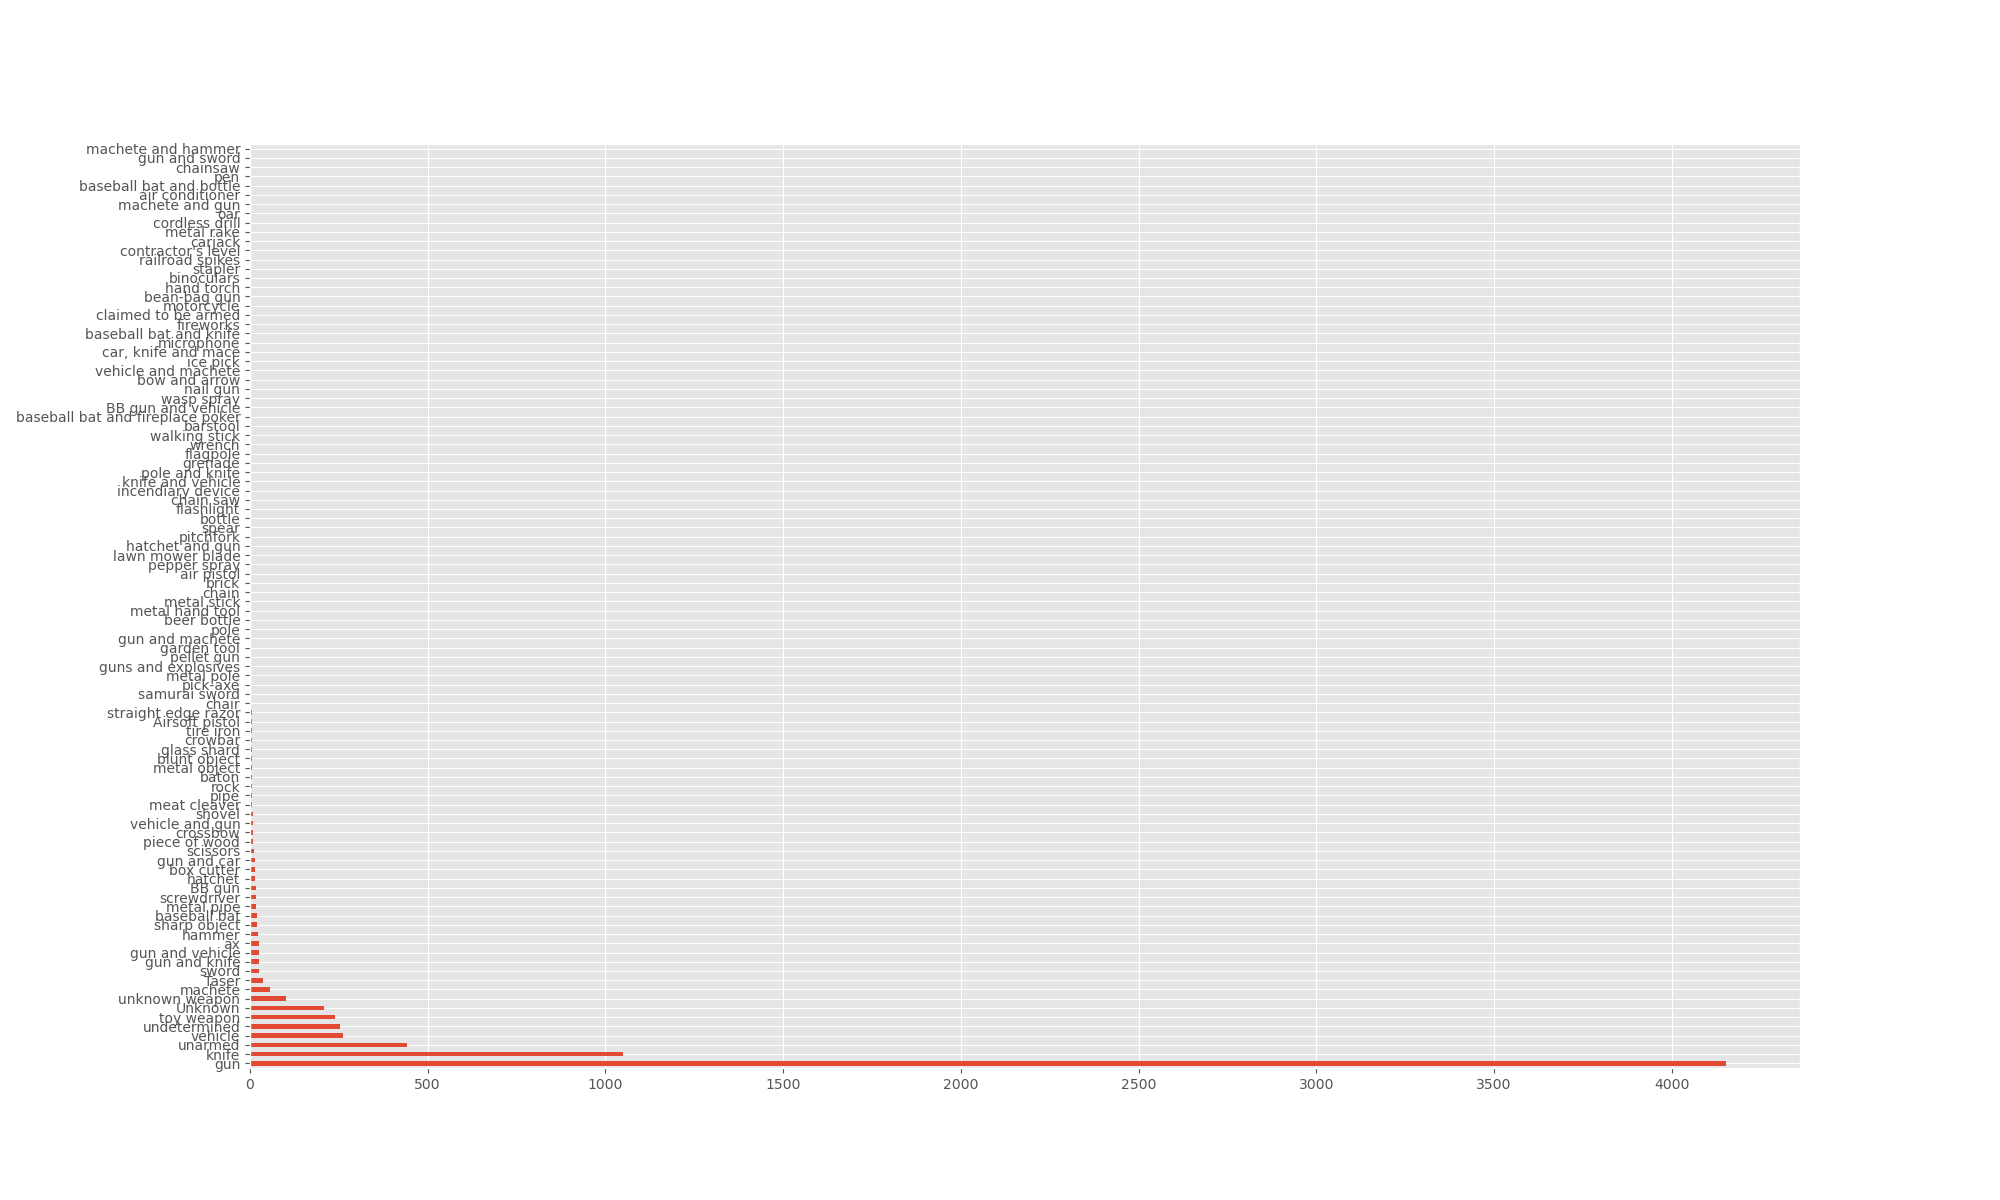

In [23]:
wp_armed_fig, wp_armed_ax = pyplot.subplots()
_ = data_wp.armed.value_counts().plot(ax=wp_armed_ax, kind="barh", figsize=(20, 12))

In [24]:
data_wp.state.value_counts(normalize=True) * 100  # Transformation % 14% des crimes se passes en CA suivit de 8 au TX et 6 a FL

CA    14.576458
TX     8.800880
FL     6.339384
AZ     4.579208
GA     3.712871
CO     3.589109
OK     2.805281
NC     2.805281
TN     2.777778
OH     2.722772
WA     2.722772
MO     2.626513
NM     2.117712
LA     2.062706
PA     2.062706
IL     2.007701
AL     1.897690
IN     1.883938
NY     1.828933
KY     1.828933
VA     1.746425
MI     1.718922
NV     1.663916
OR     1.608911
SC     1.567657
WI     1.526403
AR     1.402640
MD     1.402640
MS     1.292629
UT     1.168867
NJ     1.168867
MN     1.100110
KS     0.907591
WV     0.907591
ID     0.838834
MA     0.728823
AK     0.673817
MT     0.632563
IA     0.618812
NE     0.508801
HI     0.508801
ME     0.412541
SD     0.330033
CT     0.302530
DC     0.288779
WY     0.288779
NH     0.275028
DE     0.233773
ND     0.206271
VT     0.151265
RI     0.068757
Name: state, dtype: float64

<IPython.core.display.Javascript object>


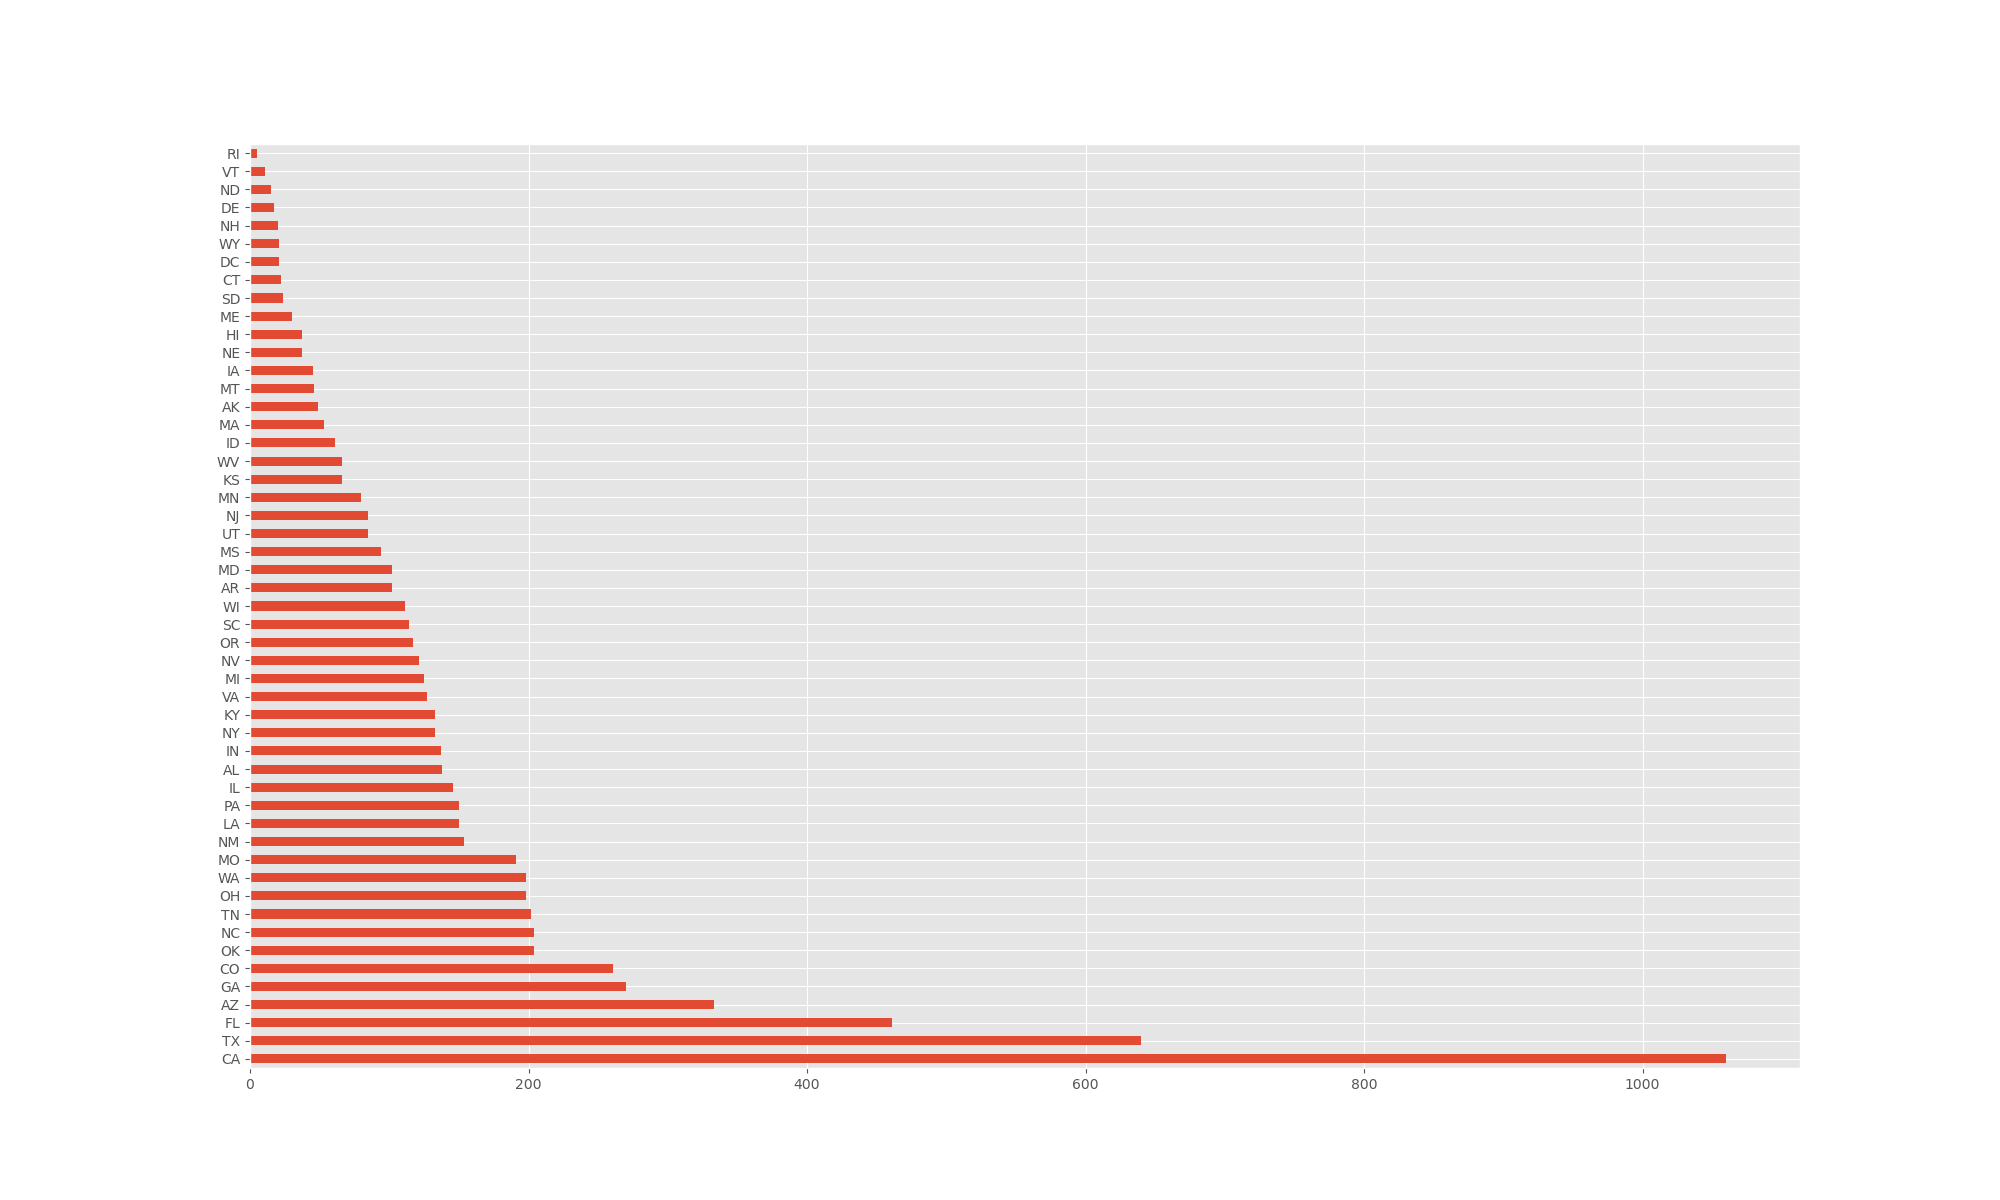

In [25]:
wp_state_plt = data_wp.state.value_counts()
wp_state_fig, wp_state_ax = pyplot.subplots()

_ = wp_state_plt.plot(ax=wp_state_ax, kind="barh", figsize=(20, 12)) # l'état comprenant le plus de crime est la Californie

In [26]:
state_data = data_wp.state.value_counts().rename_axis("state_code").reset_index(name="number_of_deaths")
state_data

state_code  number_of_deaths
0          CA              1060
1          TX               640
2          FL               461
3          AZ               333
4          GA               270
5          CO               261
6          OK               204
7          NC               204
8          TN               202
9          OH               198
10         WA               198
11         MO               191
12         NM               154
13         LA               150
14         PA               150
15         IL               146
16         AL               138
17         IN               137
18         NY               133
19         KY               133
20         VA               127
21         MI               125
22         NV               121
23         OR               117
24         SC               114
25         WI               111
26         AR               102
27         MD               102
28         MS                94
29         UT                85
30         NJ                85
31         MN                80
32         KS                66
33         WV                66
34         ID                61
35         MA                53
36         AK                49
37         MT                46
38         IA                45
39         NE                37
40         HI                37
41         ME                30
42         SD                24
43         CT                22
44         DC                21
45         WY                21
46         NH                20
47         DE                17
48         ND                15
49         VT                11
50         RI                 5

In [27]:
data_wp["year"] = pandas.DatetimeIndex(data_wp["date"]).year  # regrouper la date par an pour avoir une vision plus globale
year_data = data_wp["year"].value_counts().rename_axis("year").reset_index(name="deaths").sort_values(by="deaths")
year_data

year  deaths
7  2022     281
6  2016     958
5  2017     981
4  2018     985
3  2015     994
2  2019     999
1  2020    1020
0  2021    1054

<IPython.core.display.Javascript object>


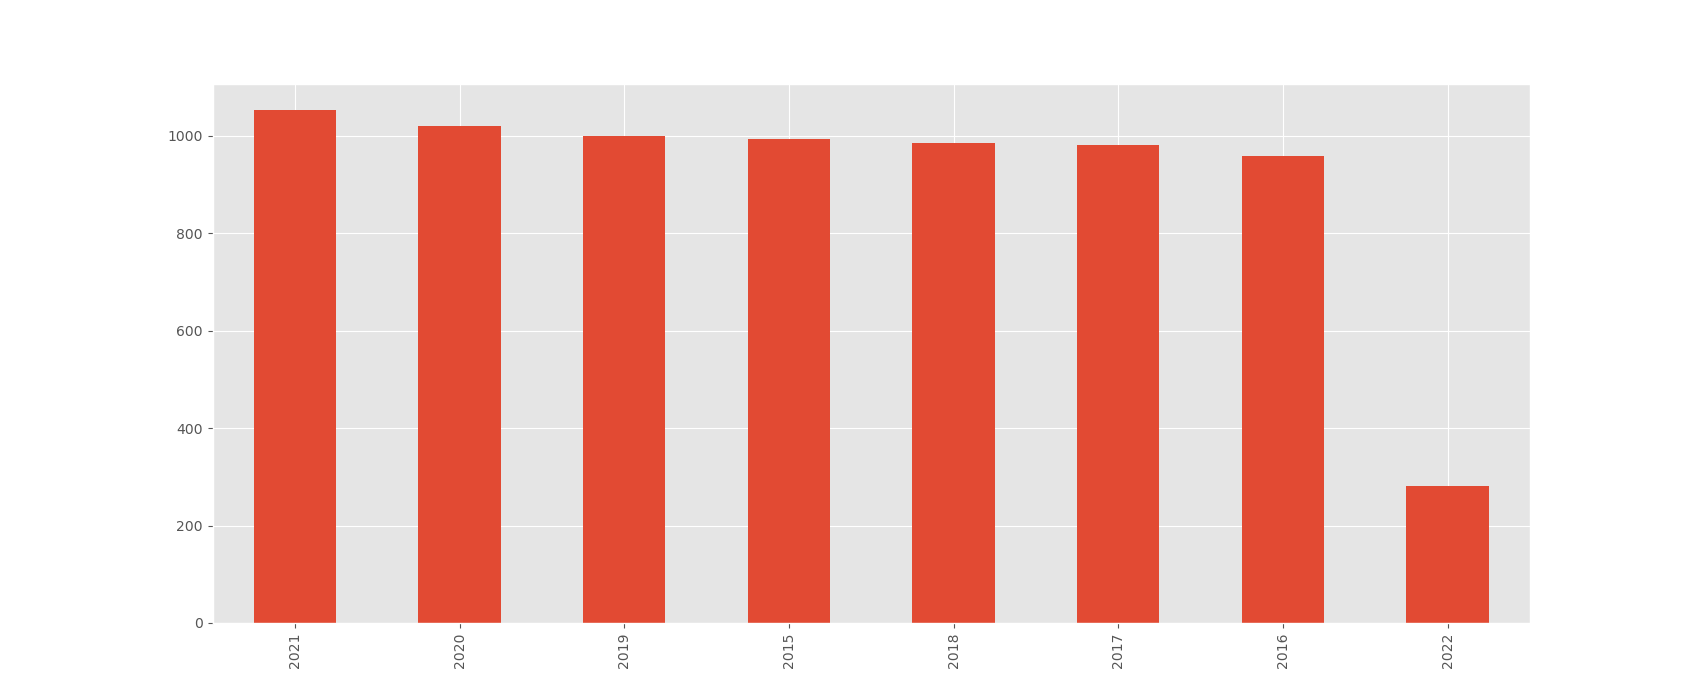

In [28]:
state_plt = data_wp.year.value_counts()
wp_state2_fig, wp_state2_ax = pyplot.subplots()

_ = state_plt.plot(ax=wp_state2_ax, kind="bar")

In [29]:
data_wp.head()

id                name       date   manner_of_death       armed   age  \
0   3          Tim Elliot 2015-01-02              shot         gun  53.0   
1   4    Lewis Lee Lembke 2015-01-02              shot         gun  47.0   
2   5  John Paul Quintero 2015-01-03  shot and Tasered     unarmed  23.0   
3   8     Matthew Hoffman 2015-01-04              shot  toy weapon  32.0   
4   9   Michael Rodriguez 2015-01-04              shot    nail gun  39.0   

  gender race           city state  signs_of_mental_illness threat_level  \
0      M    A        Shelton    WA                     True       attack   
1      M    W          Aloha    OR                    False       attack   
2      M    H        Wichita    KS                    False        other   
3      M    W  San Francisco    CA                     True       attack   
4      M    H          Evans    CO                    False       attack   

          flee  body_camera  longitude latitude  is_geocoding_exact  year  
0  Not fleeing        False   -123.122   47.247                True  2015  
1  Not fleeing        False   -122.892   45.487                True  2015  
2  Not fleeing        False    -97.281   37.695                True  2015  
3  Not fleeing        False   -122.422   37.763                True  2015  
4  Not fleeing        False   -104.692   40.384                True  2015

## Analyse de "PoliceDeaths.csv"

In [30]:
data_pd = pandas.read_csv("../data/PoliceDeaths.csv", index_col=None, parse_dates=["date"], date_parser=pandas.to_datetime)
data_pd["state"] = data_pd["state"].map(lambda state: state.strip())

pd_state_data = pandas.DataFrame(
	data=data_pd["state"].value_counts().reset_index().values,
	columns=["State", "Number of deaths"]
).sort_values("State", ascending=True)

data_pd

person  \
0         Constable Darius Quimby   
1      Sheriff Cornelius Hogeboom   
2      Deputy Sheriff Isaac Smith   
3          Marshal Robert Forsyth   
4          Sheriff Robert Maxwell   
...                           ...   
22795                    K9 Bruno   
22796                    K9 Lazer   
22797                    K9 Tyson   
22798                    K9 Credo   
22799                   K9 Roscoe   

                                                    dept  \
0                   Albany County Constable's Office, NY   
1                   Columbia County Sheriff's Office, NY   
2            Westchester County Sheriff's Department, NY   
3      United States Department of Justice - United S...   
4                 Greenville County Sheriff's Office, SC   
...                                                  ...   
22795                     Amarillo Police Department, TX   
22796  United States Department of Homeland Security ...   
22797               Fountain County Sheriff's Office, IN   
22798                   Long Beach Police Department, CA   
22799                       Emmett Police Department, ID   

                                   eow                                 cause  \
0         EOW: Monday, January 3, 1791               Cause of Death: Gunfire   
1      EOW: Saturday, October 22, 1791               Cause of Death: Gunfire   
2          EOW: Thursday, May 17, 1792               Cause of Death: Gunfire   
3      EOW: Saturday, January 11, 1794               Cause of Death: Gunfire   
4       EOW: Sunday, November 12, 1797               Cause of Death: Gunfire   
...                                ...                                   ...   
22795       EOW: Sunday, June 12, 2016            Cause of Death: Accidental   
22796       EOW: Monday, June 20, 2016       Cause of Death: Heat exhaustion   
22797       EOW: Monday, June 27, 2016       Cause of Death: Heat exhaustion   
22798      EOW: Tuesday, June 28, 2016  Cause of Death: Gunfire (Accidental)   
22799        EOW: Friday, July 1, 2016   Cause of Death: Automobile accident   

                cause_short       date  year  canine  \
0                   Gunfire 1791-01-03  1791   False   
1                   Gunfire 1791-10-22  1791   False   
2                   Gunfire 1792-05-17  1792   False   
3                   Gunfire 1794-01-11  1794   False   
4                   Gunfire 1797-11-12  1797   False   
...                     ...        ...   ...     ...   
22795            Accidental 2016-06-12  2016    True   
22796       Heat exhaustion 2016-06-20  2016    True   
22797       Heat exhaustion 2016-06-27  2016    True   
22798  Gunfire (Accidental) 2016-06-28  2016    True   
22799   Automobile accident 2016-07-01  2016    True   

                                               dept_name state  
0                       Albany County Constable's Office    NY  
1                       Columbia County Sheriff's Office    NY  
2                Westchester County Sheriff's Department    NY  
3      United States Department of Justice - United S...    US  
4                     Greenville County Sheriff's Office    SC  
...                                                  ...   ...  
22795                         Amarillo Police Department    TX  
22796  United States Department of Homeland Security ...    US  
22797                   Fountain County Sheriff's Office    IN  
22798                       Long Beach Police Department    CA  
22799                           Emmett Police Department    ID  

[22800 rows x 10 columns]

In [31]:
data_pd.head()

person  \
0     Constable Darius Quimby   
1  Sheriff Cornelius Hogeboom   
2  Deputy Sheriff Isaac Smith   
3      Marshal Robert Forsyth   
4      Sheriff Robert Maxwell   

                                                dept  \
0               Albany County Constable's Office, NY   
1               Columbia County Sheriff's Office, NY   
2        Westchester County Sheriff's Department, NY   
3  United States Department of Justice - United S...   
4             Greenville County Sheriff's Office, SC   

                               eow                    cause cause_short  \
0     EOW: Monday, January 3, 1791  Cause of Death: Gunfire     Gunfire   
1  EOW: Saturday, October 22, 1791  Cause of Death: Gunfire     Gunfire   
2      EOW: Thursday, May 17, 1792  Cause of Death: Gunfire     Gunfire   
3  EOW: Saturday, January 11, 1794  Cause of Death: Gunfire     Gunfire   
4   EOW: Sunday, November 12, 1797  Cause of Death: Gunfire     Gunfire   

        date  year  canine                                          dept_name  \
0 1791-01-03  1791   False                   Albany County Constable's Office   
1 1791-10-22  1791   False                   Columbia County Sheriff's Office   
2 1792-05-17  1792   False            Westchester County Sheriff's Department   
3 1794-01-11  1794   False  United States Department of Justice - United S...   
4 1797-11-12  1797   False                 Greenville County Sheriff's Office   

  state  
0    NY  
1    NY  
2    NY  
3    US  
4    SC

#### Infos

In [32]:
data_pd.shape

(22800, 10)

In [33]:
data_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22800 entries, 0 to 22799
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   person       22800 non-null  object        
 1   dept         22800 non-null  object        
 2   eow          22800 non-null  object        
 3   cause        22800 non-null  object        
 4   cause_short  22800 non-null  object        
 5   date         22800 non-null  datetime64[ns]
 6   year         22800 non-null  int64         
 7   canine       22800 non-null  bool          
 8   dept_name    22800 non-null  object        
 9   state        22800 non-null  object        
dtypes: bool(1), datetime64[ns](1), int64(1), object(7)
memory usage: 1.6+ MB


22800 personnes en tout avec 9 informations par personne.

#### Données manquantes

In [34]:
data_pd.isna().sum()

person         0
dept           0
eow            0
cause          0
cause_short    0
date           0
year           0
canine         0
dept_name      0
state          0
dtype: int64

Il ne nous manque aucune donnée.

#### Nombre de données totales

In [35]:
nb_data = data_pd.shape[1] * data_pd.shape[0]
nb_data

228000

#### Données dupliquées

In [36]:
data_pd.duplicated().sum()

0

Nous n'avons aucunes données dupliquées

#### Moyenne, écart-type, minimum, etc

In [37]:
data_pd.describe()

year
count  22800.000000
mean    1951.751272
std       38.233234
min     1791.000000
25%     1924.000000
50%     1952.000000
75%     1983.000000
max     2016.000000

#### Nombre de valeurs canine

In [38]:
data_pd.canine.value_counts()

False    22537
True       263
Name: canine, dtype: int64

In [39]:
data_pd.canine.value_counts(normalize=True)*100 #Transformation %

False    98.846491
True      1.153509
Name: canine, dtype: float64

<IPython.core.display.Javascript object>


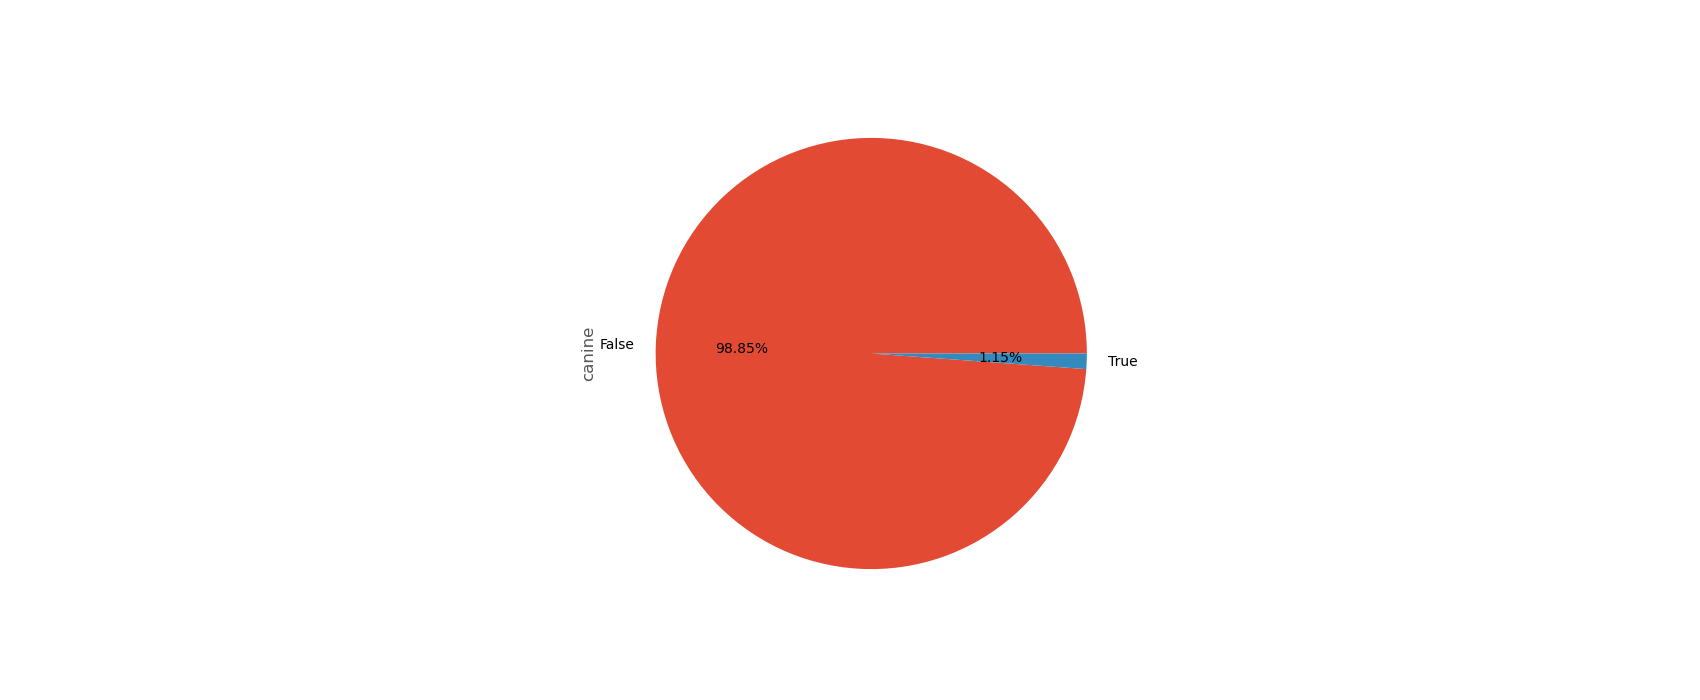

In [40]:
pd_canine_fig, pd_canine_ax = pyplot.subplots()
_ = data_pd.canine.value_counts().plot(ax=pd_canine_ax, kind="pie", autopct="%1.2f%%")

#### Répartition par État

<IPython.core.display.Javascript object>


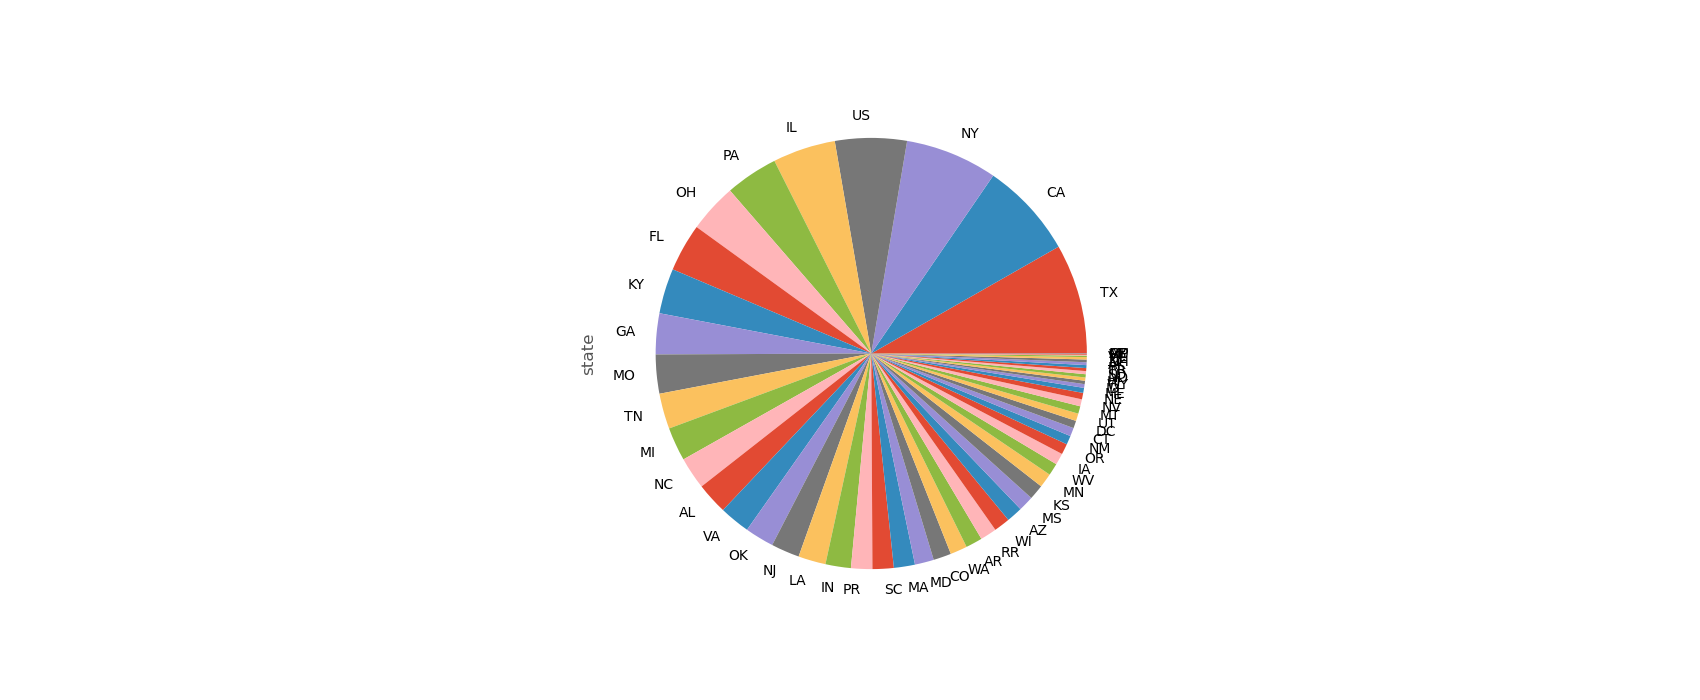

In [41]:
pd_state_fig, pd_state_ax = pyplot.subplots()
_ = data_pd.state.value_counts().plot(ax=pd_state_ax, kind="pie")

L'état comprenant le plus de morts de policiers est le Texas, suivi par la Californie et l'état de New York.

#### Répartition par cause de décès

<IPython.core.display.Javascript object>


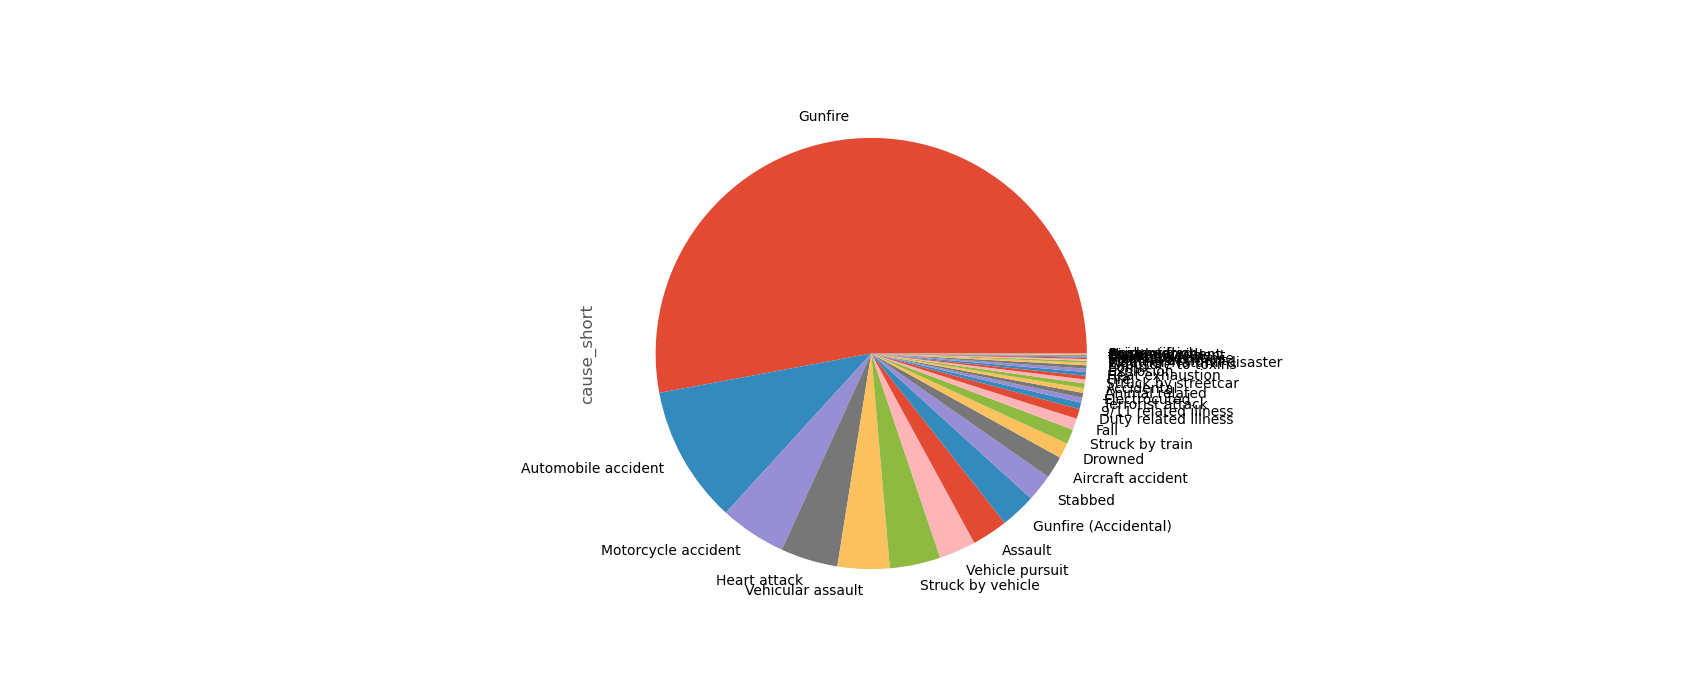

In [42]:
pd_cause_fig, pd_cause_ax = pyplot.subplots()
_ = data_pd.cause_short.value_counts().plot(ax=pd_cause_ax, kind="pie")

On peut voir que la cause de mort principale sont les armes à feu, ensuite les accidents de voiture.

### Impact de la localisation (par état et par emplacement)

In [43]:
data_pd["state"].value_counts()

TX    1880
CA    1639
NY    1574
US    1225
IL    1073
PA     901
OH     834
FL     820
KY     772
GA     698
MO     666
TN     607
MI     574
NC     549
AL     537
VA     523
OK     496
NJ     485
LA     470
IN     434
PR     363
SC     362
MA     360
MD     325
CO     305
WA     290
AR     284
RR     280
WI     275
AZ     273
MS     261
KS     257
MN     244
WV     208
IA     197
OR     182
NM     151
CT     144
DC     128
UT     128
MT     128
NV     120
NE     110
ME      86
ID      64
WY      57
HI      56
ND      55
SD      53
TR      51
RI      50
AK      48
NH      46
DE      41
VT      26
VI      14
GU      12
CZ       3
AS       3
MP       3
Name: state, dtype: int64

In [44]:
pd_state_data

State Number of deaths
51    AK               48
14    AL              537
26    AR              284
58    AS                3
29    AZ              273
1     CA             1639
24    CO              305
37    CT              144
57    CZ                3
38    DC              128
53    DE               41
7     FL              820
9     GA              698
56    GU               12
46    HI               56
34    IA              197
44    ID               64
4     IL             1073
19    IN              434
31    KS              257
8     KY              772
18    LA              470
22    MA              360
23    MD              325
43    ME               86
12    MI              574
32    MN              244
10    MO              666
59    MP                3
30    MS              261
40    MT              128
13    NC              549
47    ND               55
42    NE              110
52    NH               46
17    NJ              485
36    NM              151
41    NV              120
2     NY             1574
6     OH              834
16    OK              496
35    OR              182
5     PA              901
20    PR              363
50    RI               50
27    RR              280
21    SC              362
48    SD               53
11    TN              607
49    TR               51
0     TX             1880
3     US             1225
39    UT              128
15    VA              523
55    VI               14
54    VT               26
25    WA              290
28    WI              275
33    WV              208
45    WY               57

In [45]:
pd_state2_fig = px.choropleth(
	pd_state_data,
    locations="State",
    color="Number of deaths", color_continuous_scale="spectral_r",
    locationmode="USA-states",
    labels={"Nombre de morts": "number_of_deaths"},
    scope="usa",
	title="Nombre de morts totales de policiers par état aux États-Unis"
)

pd_state2_fig.show()

On observe sur cette carte la répartition géographique du nombre de morts de policiers selon l'état. On ne peut pas vraiment conclure d'une corrélation entre la situation géographique d'un état et son nombre de policiers tués en service.

In [46]:
pd_state3_fig = px.bar(pd_state_data, x="State", y="Number of deaths", text_auto=".2s", title="Nombre de morts totales de policiers par état aux États-Unis")
pd_state3_fig.update_traces(textfont_size=20, textangle=0, textposition="outside", cliponaxis=False)
pd_state3_fig.show()

L'état du Texas est l'état qui comporte le plus de morts de policiers totales au cours de ce siècle dernier avec plus de 1900 décès totaux.

### Étude par an

In [47]:
data_pd["year"].value_counts()

1930    323
1927    305
1932    301
1931    296
1924    289
       ... 
1824      1
1827      1
1828      1
1830      1
1792      1
Name: year, Length: 202, dtype: int64

In [48]:
year_data = data_pd["year"].value_counts().rename_axis("year").reset_index(name="number_of_deaths").sort_values(by="year")
year_data

year  number_of_deaths
181  1791                 2
201  1792                 1
186  1794                 1
187  1797                 1
188  1804                 1
..    ...               ...
67   2012               157
85   2013               141
62   2014               165
68   2015               157
121  2016                76

[202 rows x 2 columns]

In [49]:
pd_deaths_fig = px.bar(year_data, x="year", y="number_of_deaths", text_auto=".2s", title="Nombre de morts totales de policiers au cours du siècle dernier")
pd_deaths_fig.update_traces(textfont_size=20, textangle=0, textposition="outside", cliponaxis=False)
pd_deaths_fig.show()

On remarque que l'année 1930 a été la plus meurtrière pour les policiers aux États-Unis avec 323 morts de policiers pendant leur service. Cela peut s'expliquer par la surcharge de travail de la police d'État à cette époque. D'après un rapport de la police de New Jersey, _"Dans les années 1930, il n'était pas rare que les policiers travaillent de douze à seize heures par jour, sans jour de repos, parfois plusieurs semaines d'affilée, pour accomplir leur mission de protection et de service."_

https://nj.gov/njsp/about/history/1930s.shtml

In [50]:
statebyyear_data = (data_pd["state"].where(data_pd["year"] == 1930)).value_counts()
statebyyear_data

NY    37
IL    27
US    21
TX    18
OK    17
MI    15
PA    11
CA    11
NJ    10
TN     9
RR     9
VA     9
MA     8
MO     8
KY     7
OH     7
FL     7
IA     7
IN     6
NC     6
GA     6
KS     6
WI     6
MN     5
LA     4
WA     4
AL     4
WV     3
ME     3
OR     3
PR     3
AR     3
NE     3
CT     3
CO     2
RI     2
NM     2
DC     2
MS     2
ND     2
MD     1
AZ     1
HI     1
SC     1
MT     1
Name: state, dtype: int64

On peut observer que cette année-là, en 1930, c'est l'état de New York qui présente le plus de morts de policiers.

In [51]:
y_causes = pandas.DataFrame()
ny_causes = data_pd["cause_short"][(data_pd.year == 1930) & (data_pd.state.str.contains("NY"))].value_counts()
ny_causes= ny_causes.rename_axis("cause").reset_index(name="number_of_deaths")
ny_causes

cause  number_of_deaths
0                Gunfire                11
1    Motorcycle accident                 9
2    Automobile accident                 5
3      Struck by vehicle                 4
4           Heart attack                 2
5   Gunfire (Accidental)                 1
6                Stabbed                 1
7      Vehicular assault                 1
8                   Fall                 1
9           Electrocuted                 1
10       Vehicle pursuit                 1

In [52]:
pd_cause2_fig = px.bar(ny_causes, x="cause", y="number_of_deaths", text_auto=".2s", title="Causes de mort de policier dans l'état de New York en 1930")
pd_cause2_fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
pd_cause2_fig.show()

La plupart de ces morts sont dues à des armes à feu, ce sont donc des policiers tombés lors de leur service durant des fusillades ou attaques à armes à feu.

### Etude des modalités des incidents

In [53]:
causes_data = data_pd["cause_short"].value_counts()
causes_data = causes_data.rename_axis("cause").reset_index(name="number_of_deaths")
causes_data

cause  number_of_deaths
0                    Gunfire             12067
1        Automobile accident              2348
2        Motorcycle accident              1134
3               Heart attack               977
4          Vehicular assault               888
5          Struck by vehicle               868
6            Vehicle pursuit               627
7                    Assault               613
8       Gunfire (Accidental)               604
9                    Stabbed               465
10         Aircraft accident               381
11                   Drowned               262
12           Struck by train               254
13                      Fall               197
14      Duty related illness               169
15      9/11 related illness               110
16          Terrorist attack                85
17              Electrocuted                83
18            Animal related                82
19                Accidental                80
20       Struck by streetcar                68
21                      Fire                63
22           Heat exhaustion                61
23                 Explosion                58
24                      Bomb                57
25        Exposure to toxins                44
26  Weather/Natural disaster                33
27         Training accident                28
28        Structure collapse                23
29            Train accident                18
30                  Exposure                14
31          Boating accident                13
32          Bicycle accident                13
33              Unidentified                 7
34                  Poisoned                 4
35              Asphyxiation                 2

In [54]:
pd_cause3_fig = px.bar(causes_data, x="cause", y="number_of_deaths", text_auto=".2s", title="Causes de mort de policier pendant leur service")
pd_cause3_fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
pd_cause3_fig.show()

## Analyse de "FatalEncounters.csv"

### Chargement des données
Nous importons le fichier CSV en spécifiant les types de chaque colonne. Ainsi, le chargement est plus rapide, car pandas n'as pas besoin de deviner le type de chacune des colonnes. Et cela permet aussi définir le type que nous souhaitons avoir, laissant ainsi moins de place au hasard.

In [5]:
data_fe = pandas.read_csv("../data/FatalEncounters.csv", dtype={
	"Unique ID": float,
	"Name": str,
	"Age": str,
	"Gender": "category",
	"Race": "category",
	"Race with imputations": "category",
	"URL of image (PLS NO HOTLINKS)": str,
	"Location of injury (address)": str,
	"Location of death (city)": str,
	"State": str,
	"Location of death (zip code)": str,
	"Location of death (country)": str,
	"Full Address": str,
	"Latitude": str,
	"Longitude": float,
	"Agency or agencies involved": str,
	"Highest level of force": "category",
	"UID Temporary": str,
	"Name Temporary": str,
	"Armed/Unarmed": str,
	"Alleged weapon": str,
	"Aggressive physical movement": str,
	"Fleeing/Not fleeing": str,
	"Description Temp": str,
	"URL Temp": str,
	"Brief description": str,
	"Dispositions/Exclusions INTERNAL USE, NOT FOR ANALYSIS": object,
	"Intended use of force (Developing)": str,
	"Supporting document link": str,
	"Foreknowledge of mental illness? INTERNAL USE, NOT FOR ANALYSIS": object,
	"Unnamed: 32": float,
	"Unnamed: 33": float,
	"Unique ID formula": float,
	"Unique identifier (redundant)": float
}, parse_dates=[" Date of injury resulting in death (month/day/year)"], date_parser=pandas.to_datetime)

Nous pouvons noter que certaines des colonnes n'ont pas un type qui semble adéquat. Par exemple, la latitude qui est une `str` plutôt qu'un `float`. En effet, cette colonne comporte des données erronées qui empêche d'interpréter chacune de ses valeurs comme un `float`. Nous réglerons le problème après avoir préparé les données.

### Premier aperçu

In [56]:
print(f"Shape : {Fore.LIGHTGREEN_EX}{data_fe.shape}{Fore.RESET}")
print(data_fe.head(n=5))
print(f"Type des colonnes : {Style.DIM}{Fore.WHITE}\n{data_fe.dtypes}{Style.RESET_ALL}")

Shape : (31498, 36)
   Unique ID                   Name Age  Gender                     Race  \
0    25746.0        Samuel H. Knapp  17    Male  European-American/White   
1    25747.0         Mark A. Horton  21    Male   African-American/Black   
2    25748.0  Phillip A. Blurbridge  19    Male   African-American/Black   
3    25749.0             Mark Ortiz  23    Male          Hispanic/Latino   
4        1.0  LaTanya Janelle McCoy  24  Female   African-American/Black   

     Race with imputations Imputation probability  \
0  European-American/White            Not imputed   
1   African-American/Black            Not imputed   
2   African-American/Black            Not imputed   
3          Hispanic/Latino            Not imputed   
4   African-American/Black            Not imputed   

  URL of image (PLS NO HOTLINKS)  \
0                            NaN   
1                            NaN   
2                            NaN   
3                            NaN   
4                       

#### Unicité des colonnes "Unique ID" et "Name"
Nous cherchons ici à vérifier que ces deux colonnes sont uniques. Nous nous attendons à ce que la colonne "Unique ID" **soit** unique. Cependant, le nom peut comporter quelques doublons.

In [57]:
def is_column_unique(col_name, display_name=None):
	display_name = display_name if display_name else col_name
	is_unique = data_fe[col_name].is_unique
	print(f"Est-ce que \"{display_name}\" est unique ? : {Fore.LIGHTGREEN_EX}{is_unique}{Fore.RESET}")

	if not is_unique:
		columns_to_print = ["Unique ID"]

		if col_name not in columns_to_print:
			columns_to_print.append(col_name)

		duplicated = data_fe[data_fe.duplicated(subset=[col_name], keep=False)][columns_to_print]
		duplicated["Count"] = duplicated.groupby(col_name)["Unique ID"].transform("count")

		print((
			f"Les valeurs non uniques de \"{display_name}\" sont:\n"
			f"{Style.DIM}{Fore.WHITE}{duplicated.drop_duplicates([col_name])}{Style.RESET_ALL}"
		))

is_column_unique("Unique ID", display_name="id")
is_column_unique("Name")

Est-ce que "id" est unique ? : True
Est-ce que "Name" est unique ? : False
Les valeurs non uniques de "Name" sont:
       Unique ID                      Name  Count
22       20792.0   Name withheld by police   1391
98          59.0              Donald Moore      2
195      28746.0                John Doe 1      5
196      28747.0                John Doe 2      5
197      28748.0                John Doe 3      4
...          ...                       ...    ...
28227    28093.0       William Johnson Jr.      2
28248    28113.0              Dion Johnson      2
30806    30781.0              Eric Padilla      2
30820    30790.0     Devonte Dawayne Brown      2
31134    31134.0  Christopher Ryan Vasquez      2

[208 rows x 3 columns]


#### Valeurs manquantes par colonnes
Nous allons maintenant essayer de voir la quantité (en pourcentage) de valeurs manquantes pour chacune des colonnes de notre jeu de données.

In [58]:
print((
	"Pourcentage total de valeur manquante : "
	f"{Fore.LIGHTGREEN_EX}{round(((data_fe.isna().sum().sum() / (data_fe.shape[0] * data_fe.shape[1])) * 100), 2)}%{Fore.RESET}"
))

percent_missing = round((data_fe.isna().sum() * 100) / len(data_fe), 2)
df_missing = pandas.DataFrame({"Column name": data_fe.columns, "Missing": percent_missing.values})
df_missing.sort_values("Missing", ascending=False, inplace=True)

print((
	f"Pourcentage de valeur manquante par colonne :\n"
	f"{Style.DIM}{Fore.WHITE}{tabulate(df_missing, showindex=False, headers=df_missing.columns)}{Style.RESET_ALL}"
))

Pourcentage total de valeur manquante : 24.75%
Pourcentage de valeur manquante par colonne :
Column name                                                        Missing
---------------------------------------------------------------  ---------
Unnamed: 33                                                         100
Unnamed: 32                                                         100
Unique ID formula                                                    99.99
URL Temp                                                             89.79
Description Temp                                                     87.09
UID Temporary                                                        82.45
Name Temporary                                                       82.45
URL of image (PLS NO HOTLINKS)                                       53.24
Armed/Unarmed                                                        45.78
Fleeing/Not fleeing                                                  45.78
Alleged weapo

Nous allons ensuite supprimer toutes les colonnes avec plus de x% (`threshold`) de données manquantes.

In [59]:
# Drop all columns with more than `drop_threshold`% of missing data
drop_threshold = 50
drop_columns = df_missing[df_missing["Missing"] >= drop_threshold]["Column name"].tolist()

if len(drop_columns) > 0:
	print((
		f"{Fore.YELLOW}Suppression des colonnes avec plus de {drop_threshold}% de données manquantes. Suppression de "
		f"{drop_columns}...{Fore.RESET}"
	))
	drop_prev_shape = data_fe.shape
	data_fe.drop(columns=drop_columns, axis=1, inplace=True)
	drop_new_shape = data_fe.shape
	drop_count = drop_prev_shape[1] - drop_new_shape[1]

	drop_plural = "s" if drop_count > 1 else ""
	print(f"{Fore.YELLOW}{drop_count} colonne{drop_plural} supprimée{drop_plural}. Nouvelle \"shape\" : {drop_new_shape}{Fore.RESET}")

Suppression des colonnes avec plus de 50% de données manquantes. Suppression de ['Unnamed: 33', 'Unnamed: 32', 'Unique ID formula', 'URL Temp', 'Description Temp', 'UID Temporary', 'Name Temporary', 'URL of image (PLS NO HOTLINKS)']...
8 colonnes supprimées. Nouvelle "shape" : (31498, 28)


### Valeurs dupliquées
Pour clore ce premier aperçu, nous allons compter le nombre de données dupliquées.

In [60]:
duplicated_data = data_fe.duplicated().sum()
print((
	f"Données dupliquées : {Fore.LIGHTGREEN_EX}{duplicated_data}{Fore.RESET}"
	f" ({round((duplicated_data * 100) / data_fe.shape[0], 1)}%)"
))

Données dupliquées : 0 (0.0%)


### Préparation des données
Avant toute analyse approfondie des données, il faut les préparer. Et notamment régler les problèmes de valeur pour certaines colonnes.

#### Suppression des colonnes à ne pas utiliser
Certaines colonnes comportent dans leur nom la mention "INTERNAL USE, NOT FOR ANALYSIS". Pour respecter cette mention, nous supprimons ces colonnes.

In [61]:
data_fe.drop(list(data_fe.filter(regex="INTERNAL USE, NOT FOR ANALYSIS")), axis=1, inplace=True)

#### Préparation de la colonne "Age"
Cette colonne ne pouvait pas être mise sous le type `float` car certaines de ses valeurs n'était pas numériques.

Certaines valeurs sont des intervalles d'âge. Deux choix sont alors possibles. Supprimer les lignes concernées ou transformer l'intervalle en moyenne. Nous avons choisi ici la deuxième solution. Pour régler le souci, nous appliquons une fonction de transformation sur la colonne.

In [62]:
def _transform_age(age):
	if isinstance(age, str):
		if "-" in age and not age.startswith("-"):
			age_range = age.split("-")
			return round(float((int(age_range[0]) + int(age_range[1])) / 2), 0)
		else:
			return round(float(age), 0)

	return round(age, 0)


data_fe["Age"] = data_fe["Age"].map(lambda age: _transform_age(age))

#### Préparation de la colonne "Latitude"
Certaines latitudes comportent des caractères invalides. La solution la plus simple les concernant et de supprimer les lignes en question.

In [63]:
wrong_latitude_index = []

def _transform_latitude(lat):
	if isinstance(lat, str):
		try:
			return float(lat)
		except ValueError:
			wrong_latitude_index.append(data_fe.index[data_fe["Latitude"] == lat])
			return lat

	return lat

data_fe["Latitude"] = data_fe["Latitude"].map(lambda lat: _transform_latitude(lat))
data_fe.drop([index for sublist in wrong_latitude_index for index in sublist], inplace=True)
data_fe = data_fe.astype({"Latitude": float})

#### Préparation de la colonne "Race"
Cette colonne pose deux problèmes. Le premier est que certaines cellules sont vides où contienne des valeurs incorrectes. Le second concerne la manière dont les ethnies sont renseignée. Chaque personne est caractérisée par une série d'ethnies séparées par un slash (/). Cependant, ce format rend compliqué l'analyse des données. Nous allons donc procéder à un `One Hot Encoding` afin de remplacer cette colonne par plusieurs colonnes correspondant à chacune des ethnies. Les valeurs de ces colonnes seront binaire, c'est-à-dire 0 où 1.

In [64]:
race_uncertain = "Race unspecified"
data_fe["Race"].fillna(race_uncertain, inplace=True)
data_fe["Race"] = data_fe["Race"].map(lambda race: race.title())
data_fe.loc[(data_fe["Race"] == "Christopher Anthony Alexander"), "Race"] = race_uncertain
data_fe = pandas.concat([
	data_fe.drop("Race", axis=1),
	data_fe["Race"].str.get_dummies(sep="/").add_prefix("Race_")
], axis=1)

#### Préparation de la colonne "Armed/Unarmed"
Cette colonne, tout comme "Fleeing/Not fleeing", et une colonne qui comporte un nombre important de valeurs manquantes. Cependant, elle peut être très utile à l'étude. Pour chacune des personnes, cette colonne à pour valeur "Armed" (armé), "Unarmed" (non armé) ou "Uncertain" (incertain). Nous allons donc remplacer les valeurs incorrectes ou nulles par "Uncertain".

In [65]:
armed_uncertain = "Uncertain"

def _transform_is_armed(is_armed):
	if isinstance(is_armed, str):
		if (is_armed.lower() == "armed") or (is_armed.lower() == "unarmed"):
			return is_armed
		elif re.match(r"duplicate|none", is_armed, flags=re.IGNORECASE):
			return armed_uncertain
		else:
			return armed_uncertain
	else:
		return armed_uncertain

data_fe["Armed/Unarmed"] = data_fe["Armed/Unarmed"].map(lambda is_armed: _transform_is_armed(is_armed))
data_fe = data_fe.astype({"Armed/Unarmed": "category"})

#### Préparation de la colonne "Fleeing/Not fleeing"
Nous avons le même intérêt pour cette colonne que "Armed/Unarmed", et elle comporte le même problème. Nous allons donc procéder de manière similaire.

In [66]:
fleeing_uncertain = "Uncertain"

def _transform_is_fleeing(is_fleeing):
	if isinstance(is_fleeing, str):
		if re.match(r"duplicate|none", is_fleeing, flags=re.IGNORECASE):
			return fleeing_uncertain
		else:
			parts = is_fleeing.lower().split("/")

			if "fleeing" in parts:
				return "Fleeing"
			elif "not fleeing" in parts:
				return "Not fleeing"
			elif fleeing_uncertain.lower() in parts:
				return fleeing_uncertain
			else:
				return fleeing_uncertain
	else:
		return fleeing_uncertain

data_fe["Fleeing/Not fleeing"] = data_fe["Fleeing/Not fleeing"].map(lambda is_fleeing: _transform_is_fleeing(is_fleeing))
data_fe = data_fe.astype({"Fleeing/Not fleeing": "category"})

#### Préparation de la colonne " Date of injury resulting in death (month/day/year)"
Cette colonne comporte un espace en trop au début. Nous réglons le problème et en profitons pour la renommer en quelque-chose de plus concis.

In [7]:
data_fe.rename({" Date of injury resulting in death (month/day/year)": "Date of death"}, axis=1, inplace=True)

Maintenant que nos transformations sont terminées, nous pouvons commencer à exploiter ce jeu de données pour une analyse statistique.

### Analyse de la fréquence

<IPython.core.display.Javascript object>


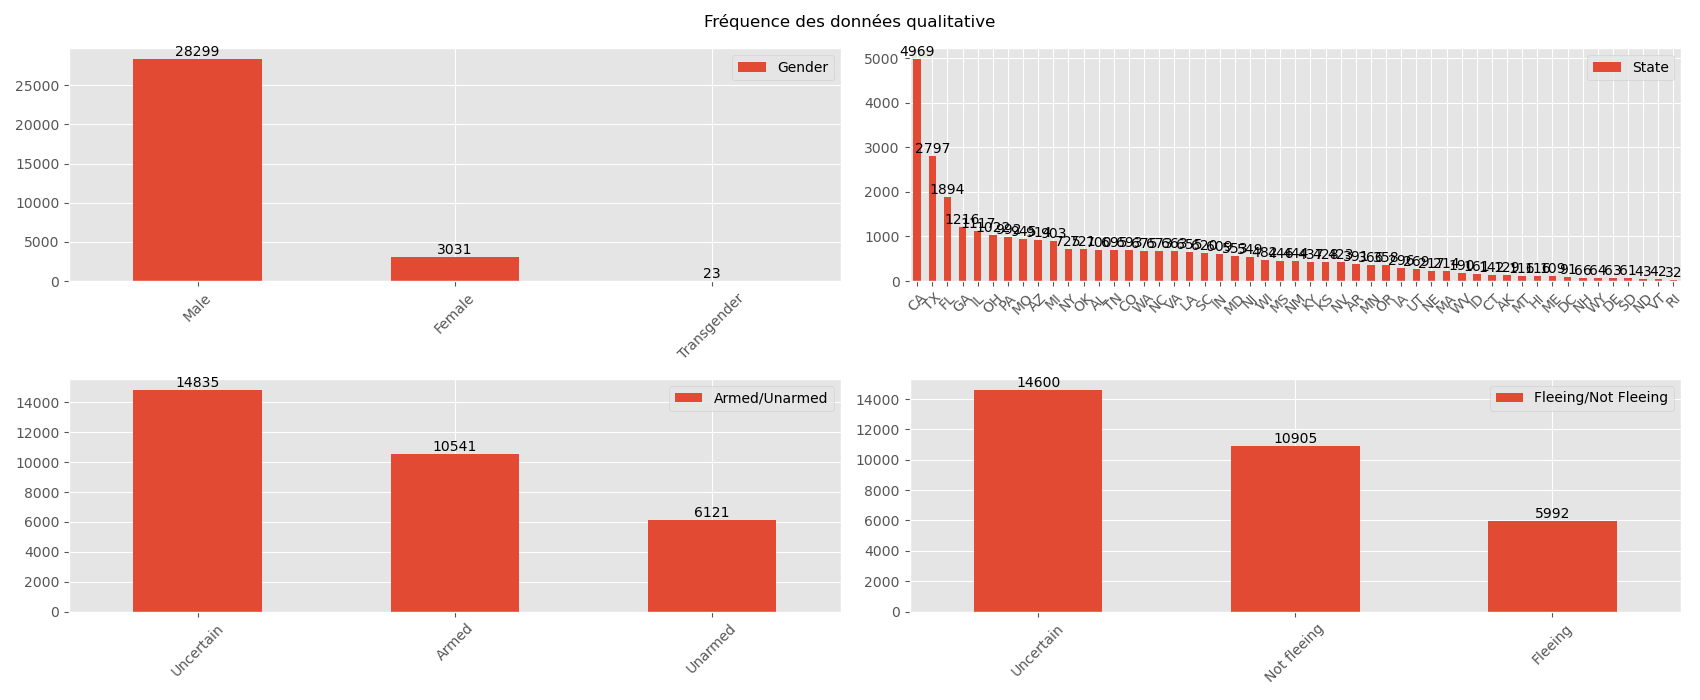

In [68]:
freq_columns = ["Gender", "State", "Armed/Unarmed", "Fleeing/Not fleeing"]
freq_n_cols = 2
freq_n_rows = math.ceil(len(freq_columns) / freq_n_cols)
freq_fig = pyplot.figure()
freq_fig.suptitle("Fréquence des données qualitative")

for index, col in enumerate(freq_columns):
	ax = pyplot.subplot(freq_n_rows, freq_n_cols, index + 1)

	data_count = data_fe[[col]].value_counts()
	labels = [label[0] for label in data_count.index.tolist()]
	bars = data_count.plot(ax=ax, kind="bar", legend=True, label=col.title())
	ax.set_xlabel("")
	ax.set_xticks(ticks=numpy.arange(0, len(data_count)), labels=labels, rotation=45, fontsize=10)

	for bars in ax.containers:
		ax.bar_label(bars)

pyplot.tight_layout()
pyplot.show()

### Analyse des champs numériques : Moyenne, Médiane, Mode, Écart-Type, Asymétrie (Skewness), Kurtosis
Notre jeu de données comporte assez peu de données numériques.

In [69]:
print(data_fe.dtypes)

Unique ID                                    float64
Name                                          object
Age                                          float64
Gender                                      category
Race with imputations                       category
Imputation probability                        object
Date of death                         datetime64[ns]
Location of injury (address)                  object
Location of death (city)                      object
State                                         object
Location of death (zip code)                  object
Location of death (county)                    object
Full Address                                  object
Latitude                                     float64
Longitude                                    float64
Agency or agencies involved                   object
Highest level of force                      category
Armed/Unarmed                               category
Alleged weapon                                

Le "Unique ID" n'est qu'un identifiant et une analyse de moyenne sur une latitude et une longitude n'a pas vraiment de sens. La seule colonne analysée sera alors "Age".

<IPython.core.display.Javascript object>


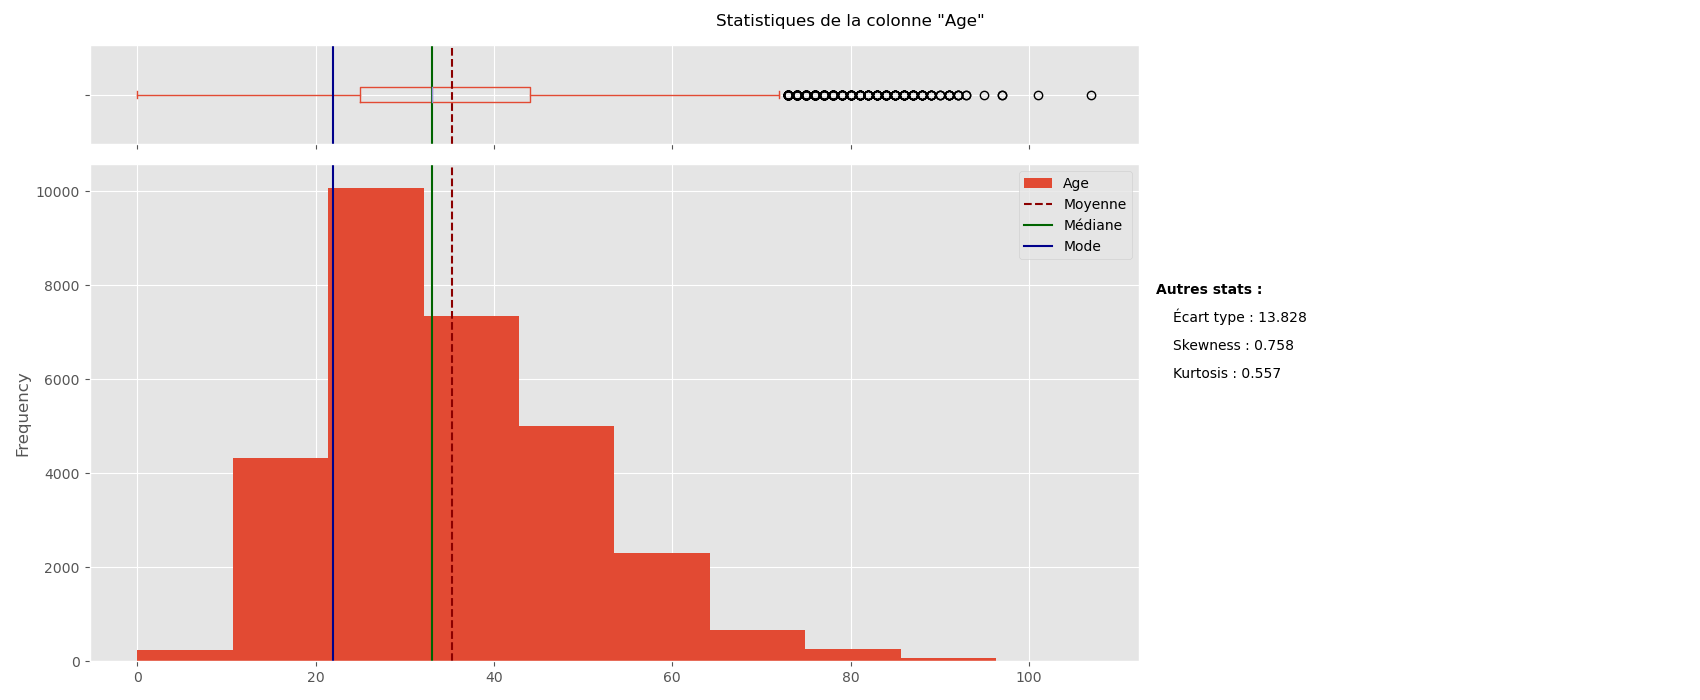

In [70]:
numerical_columns = ["Age"]

for column in numerical_columns:
	# noinspection PyTypeChecker
	mmmssk_fig, (mmmssk_box_ax, mmmssk_hist_ax) = pyplot.subplots(
		nrows=2, ncols=1,
		sharex=True,
		gridspec_kw={"height_ratios": (0.2, 1)}
	)
	mmmssk_fig.suptitle(f"Statistiques de la colonne \"{column}\"")

	mean = data_fe[column].mean()
	median = data_fe[column].median()
	mode = data_fe[column].mode().values[0]

	data_fe[column].plot(ax=mmmssk_box_ax, kind="box", vert=False, legend=True)
	mmmssk_box_ax.axvline(mean, color="darkred", linestyle="--")
	mmmssk_box_ax.axvline(median, color="darkgreen", linestyle="-")
	mmmssk_box_ax.axvline(mode, color="darkblue", linestyle="-")

	data_fe[column].plot(ax=mmmssk_hist_ax, kind="hist", legend=True)
	mmmssk_hist_ax.axvline(mean, color="darkred", linestyle="--", label="Moyenne")
	mmmssk_hist_ax.axvline(median, color="darkgreen", linestyle="-", label="Médiane")
	mmmssk_hist_ax.axvline(mode, color="darkblue", linestyle="-", label="Mode")

	mmmssk_box_ax.set_yticklabels([""])
	mmmssk_hist_ax.legend()

	standard_deviation = data_fe[column].std()
	skewness = data_fe[column].skew()
	kurtosis = data_fe[column].kurtosis()

	pyplot.figtext(0.68, 0.58, f"Autres stats :", fontsize=10, fontweight="bold")
	pyplot.figtext(0.69, 0.54, f"Écart type : {round(standard_deviation, 3)}", fontsize=10)
	pyplot.figtext(0.69, 0.5, f"Skewness : {round(skewness, 3)}", fontsize=10)
	pyplot.figtext(0.69, 0.46, f"Kurtosis : {round(kurtosis, 3)}", fontsize=10)

	pyplot.tight_layout()
	pyplot.subplots_adjust(right=0.67)
	pyplot.show()

### Répartition des confrontations fatales entre citoyen et policier
Nous allons chercher à voir la répartition de ces confrontations selon plusieurs variables. Nous pourrons ainsi voir quelles sont les personnes les plus touchés par ça.

<IPython.core.display.Javascript object>


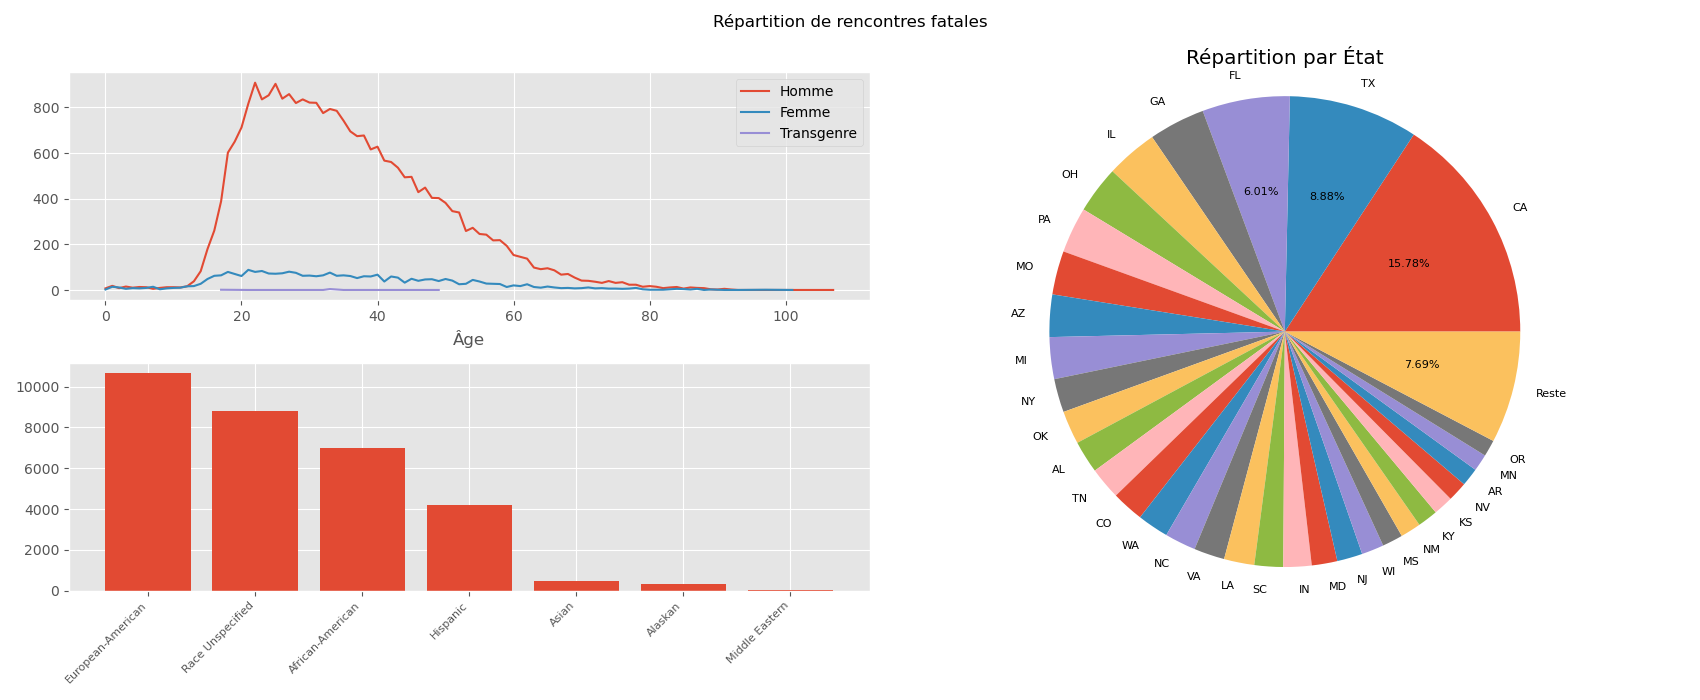

In [71]:
repart_fig = pyplot.figure()
repart_size = (2, 2)
repart_grid = repart_fig.add_gridspec(repart_size[0], repart_size[1])

_ = repart_fig.suptitle("Répartition de rencontres fatales")

#### Répartition par âge et par sexe

In [72]:
male_labels = data_fe["Age"][data_fe["Gender"] == "Male"].drop_duplicates(keep="first", inplace=False).dropna().sort_values()
male_values = data_fe["Age"][data_fe["Gender"] == "Male"].value_counts().sort_index()

female_labels = data_fe["Age"][data_fe["Gender"] == "Female"].drop_duplicates(keep="first", inplace=False).dropna().sort_values()
female_values = data_fe["Age"][data_fe["Gender"] == "Female"].value_counts().sort_index()

trans_labels = data_fe["Age"][data_fe["Gender"] == "Transgender"].drop_duplicates(keep="first", inplace=False).dropna().sort_values()
trans_values = data_fe["Age"][data_fe["Gender"] == "Transgender"].value_counts().sort_index()

gender_ax = pyplot.subplot(repart_grid[0, :-1])
gender_ax.plot(male_labels, male_values.tolist(), label="Homme")
gender_ax.plot(female_labels, female_values.tolist(), label="Femme")
gender_ax.plot(trans_labels, trans_values.tolist(), label="Transgenre")

gender_ax.set_xlabel("Âge")
_ = gender_ax.legend()

#### Répartition par ethnies

In [73]:
# Revert one hot encoding
ethnic_data = data_fe[[column for column in data_fe if column.startswith("Race_")]].idxmax(1)
ethnic_data = ethnic_data.map(lambda ethnic: ethnic.replace("Race_", "").title())

ethnic_values = ethnic_data.value_counts().sort_values(ascending=False)
ethnic_labels = pandas.Series(data=ethnic_values.index, index=ethnic_values)

ethnic_ax = pyplot.subplot(repart_grid[1, :-1])
ethnic_ax.bar(ethnic_labels, ethnic_values.tolist())

_ = ethnic_ax.set_xticks(
	ticks=numpy.arange(0, len(ethnic_labels)),
	labels=ethnic_labels,
	rotation=45, fontsize=8, ha="right"
)

#### Répartition par État

In [74]:
# Fatal encounters per state
def autopct_func(pct):
	return f"{round(pct, 2)}%" if pct > 5 else ""

# Get states
states = data_fe["State"].sort_values()
states_values = states.value_counts().sort_values(ascending=False)

# Merge states with low values
states_threshold = 1
states_to_merge = states_values[states_values <= ((states_values.sum() * states_threshold) / 100)]
states_values = pandas.concat([
	states_values.drop(states_values.tail(n=len(states_to_merge)).index),
	pandas.Series(data=sum(states_to_merge), index=["Reste"])
])

# Get states labels
states_labels = pandas.Series(data=states_values.index, index=states_values)

# Plot
states_ax = pyplot.subplot(repart_grid[0:, -1])
states_ax.pie(states_values.tolist(), labels=states_labels, autopct=autopct_func, textprops={"fontsize": 8})
states_ax.axis("equal")
_ = states_ax.set_title("Répartition par État")

Enfin, il ne reste qu'à afficher les graphiques.

In [75]:
pyplot.tight_layout()
pyplot.show()

### Test du khi-deux

<IPython.core.display.Javascript object>


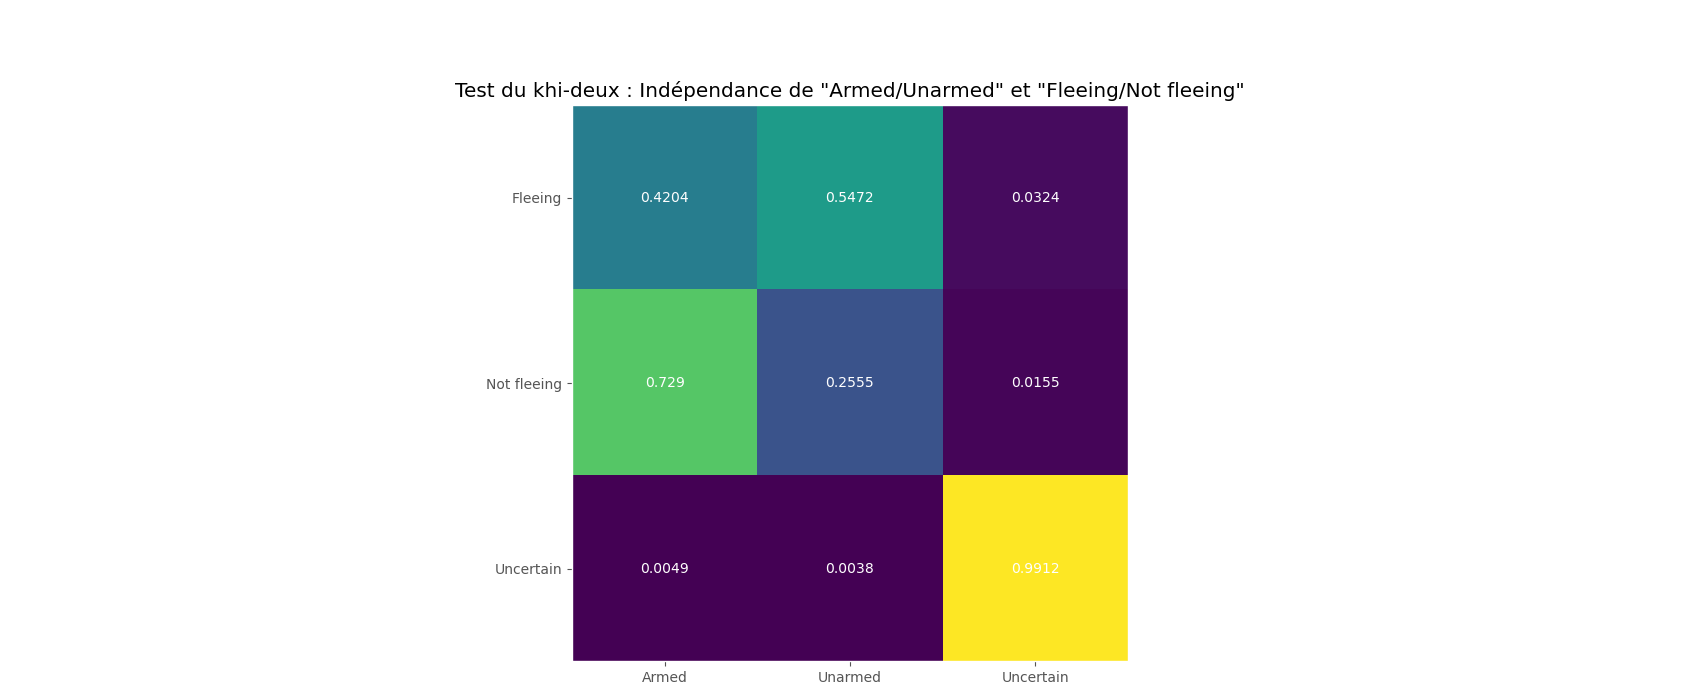

Degrés de liberté : 4
Fréquence attendue : [[0.38477949 0.26884229 0.34637821]
 [0.38477949 0.26884229 0.34637821]
 [0.38474101 0.26881541 0.34634357]]
Interprétation de test-statistic: (Probability: 0.95 | Critical: 9.488 | Stat: 3.038) >>> Dépendant: Non
Interprétation de p-value: (Significance: 0.05 | P-Value: 0.552) >>> Dépendant: Non


In [76]:
# Contingency table
contingency = pandas.crosstab(
	index=data_fe["Fleeing/Not fleeing"],
	columns=data_fe["Armed/Unarmed"],
	normalize="index"
).round(4)
contingency_numpy = contingency.to_numpy()

chi_labels_armed = contingency.columns.tolist()
chi_labels_fleeing = contingency.index.tolist()

# Plot to heatmap
chi_fig, chi_ax = pyplot.subplots()

chi_ax.imshow(contingency_numpy)
chi_ax.set_xticks(numpy.arange(len(chi_labels_armed)), labels=chi_labels_armed)
chi_ax.set_yticks(numpy.arange(len(chi_labels_fleeing)), labels=chi_labels_fleeing)

for i in range(len(chi_labels_fleeing)):
	for j in range(len(chi_labels_armed)):
		chi_ax.text(j, i, contingency_numpy[i, j], ha="center", va="center", color="w")

# Interpret statistics
stat, pvalue, dof, expected = scipy.stats.chi2_contingency(contingency)

print(f"Degrés de liberté : {Fore.LIGHTGREEN_EX}{dof}{Fore.RESET}")
print(f"Fréquence attendue : {Fore.LIGHTGREEN_EX}{expected}{Fore.RESET}")

prob = 0.95
critical = scipy.stats.chi2.ppf(prob, dof)
print((
	f"Interprétation de test-statistic: "
	f"{Style.DIM}{Fore.WHITE}(Probability: {round(prob, 3)} | Critical: {round(critical, 3)} | Stat: {round(stat, 3)}) "
	f"{Style.RESET_ALL}{Fore.LIGHTGREEN_EX}>>> Dépendant: {'Oui' if (abs(stat) >= critical) else 'Non'}{Fore.RESET}"
))

alpha = 1.0 - prob
print((
	f"Interprétation de p-value: "
	f"{Style.DIM}{Fore.WHITE}(Significance: {round(alpha, 3)} | P-Value: {round(pvalue, 3)}) "
	f"{Style.RESET_ALL}{Fore.LIGHTGREEN_EX}>>> Dépendant: {'Oui' if (pvalue <= alpha) else 'Non'}{Fore.RESET}"
))

# Finish plot
chi_ax.set_title(
	"Test du khi-deux : Indépendance de \"Armed/Unarmed\" et \"Fleeing/Not fleeing\"",
	loc="center",
	wrap=True
)
chi_ax.grid(False)
chi_fig.tight_layout()
chi_fig.subplots_adjust(top=0.85)
pyplot.show()

## Analyse de "TaxPolicyCenter.xls"

### Mise en forme de départ
Le fichier Excel nécessite un traitement de départ pour pouvoir exploiter les données.
Pour quelques-uns de nos calculs, nous utiliserons la feuille '2019' qui contient les données les plus récentes.

In [77]:
tax_data = pandas.read_excel(
    "../data/TaxPolicyCenter.xls",
    skiprows=5, skipfooter=4, # On ne prend pas en compte les lignes informatiques du header et du footer
    header=[0,1,2], # Les noms des colonnes sont sur trois lignes, nous traiterons donc ces lignes comme une seule ligne
    sheet_name=None
)
tax_sample = tax_data["2019"]

La boucle réalisera des traitements sur chaque feuille du fichier.
D'abord, nous renommons les colonnes (puisque le header se compose de trois lignes) pour obtenir des noms cohérents.
Nous récupérons également quelques données qui seront utilisées plus tard pour les graphiques et certains calculs.

In [78]:
tax_total_data = 0
total_income_list = []
police_budget = []
budget_years = []
print("===================Data INFO=====================")
tax_sample.info() #71 états/collectivités avec 11 colonnes de dépenses
for sheet in tax_data :
    income = 0
    df = tax_data[sheet]
    df.columns = ["_".join(index_str) for index_str in df.columns.to_flat_index()]
    df.rename(columns={
        "Unnamed: 0_level_0_Region and State_Unnamed: 0_level_2": "Region and State","Unnamed: 1_level_0_Region and State_Total": "Total",
        "Unnamed: 2_level_0_Inter-_governmental": "Inter-governmental",
        "Unnamed: 3_level_0_Inter-_Total": "Direct Total",
        "Elementary_and Secondary_Education": "Elementary and Secondary Education",
        "Elementary_Higher_Education": "Higher Education",
        "Elementary_Public_Welfare": "Public Welfare",
        "Elementary_Health and_Hospitals": "Health and Hospitals",
        "Elementary_Health and_Highways": "Highways",
        "Elementary_Health and_Police": "Police",
        "Elementary_All_Other": "All Other",
        "Personal_Income [1]_(Millions)": "Personal Income [1] (Millions)"
    }, inplace=True)
    print("===================Données manquantes pour " + sheet + " ?=====================")
    print(df.isna().sum()) # On vérifie si des valeurs sont manquantes
    df.dropna(inplace=True) # Suppression des lignes avec une valeur manquantes
    tax_total_data += df.shape[1]*df.shape[0] # On ajoute le total des données de la feuille dans une variable
    total_income_list.insert(0,(df.iloc[0]["Personal Income [1] (Millions)"])) # On ajoute
    police_budget.insert(0,(df.iloc[0]["Personal Income [1] (Millions)"])/100*(df.iloc[0]["Police"]*100))
    budget_years.insert(0, sheet)
tax_sample["All years income"] = pandas.Series(total_income_list)
tax_sample["Police budget evolution"] = pandas.Series(police_budget)

===================Data INFO=====================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 12 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   (Unnamed: 0_level_0, Region and State, Unnamed: 0_level_2)  60 non-null     object 
 1   (Unnamed: 1_level_0, Region and State, Total)               60 non-null     float64
 2   (Unnamed: 2_level_0, Inter-, governmental)                  60 non-null     float64
 3   (Unnamed: 3_level_0, Inter-, Total)                         60 non-null     float64
 4   (Elementary, and Secondary, Education)                      60 non-null     float64
 5   (Elementary, Higher, Education)                             60 non-null     float64
 6   (Elementary, Public, Welfare)                               60 non-null     float64
 7   (Elementary, Health and, Hospitals)      

In [79]:
print("===================Total des données=====================")
print(tax_total_data)

===================Total des données=====================
11520


Nous affichons des statistiques sur toutes les colonnes. Celles qui nous intéressent le plus sont les colonnes Police, All years income et Police budget evolution.

In [80]:
print("===================Description et stats=====================")
print(tax_sample.describe())

===================Description et stats=====================
           Total  Inter-governmental  Direct Total  \
count  60.000000           60.000000     60.000000   
mean   18.281756            0.007065     18.274691   
std     3.785900            0.020820      3.783119   
min     0.180093            0.000000      0.179921   
25%    16.517344            0.000000     16.517344   
50%    18.147631            0.000018     18.147577   
75%    19.794667            0.001935     19.794667   
max    28.095157            0.108886     28.095157   

       Elementary and Secondary Education  Higher Education  Public Welfare  \
count                           60.000000         60.000000       60.000000   
mean                             3.867793          1.767521        4.031424   
std                              0.797018          0.613697        1.352895   
min                              0.038711          0.016792        0.040109   
25%                              3.579619          1.2802

Bien que les statistiques précédentes nous montrent une moyenne, une médiane et d'autres informations, nous les affichons tout de même ici sous une forme plus lisible.

In [81]:
print("===================Moyenne=====================")
print("All years income :", tax_sample["All years income"].mean())
print("Police budget :", tax_sample["Police budget evolution"].mean())

===================Moyenne=====================
All years income : 14335731.153846154
Police budget : 99998.42100129538


In [82]:
print("===================Médiane=====================")
print("All years income :", tax_sample["All years income"].median())
print("Police budget :", tax_sample["Police budget evolution"].median())

===================Médiane=====================
All years income : 13998383.0
Police budget : 96875.94953533


In [83]:
print("===================Skew=====================")
print("All years income :", tax_sample["All years income"].skew())
print("Police budget :", tax_sample["Police budget evolution"].skew())

===================Skew=====================
All years income : 0.3442130183886384
Police budget : -0.025606281986510004


Pour les graphiques nous avons choisi un graphique de courbe, car il est le plus explicite concernant les données sur une période en années.
C'est ici que nous utilisons les listes contenant les valeurs récupérées lors de la boucle.

#### Évolution du revenu intérieur des USA

<IPython.core.display.Javascript object>


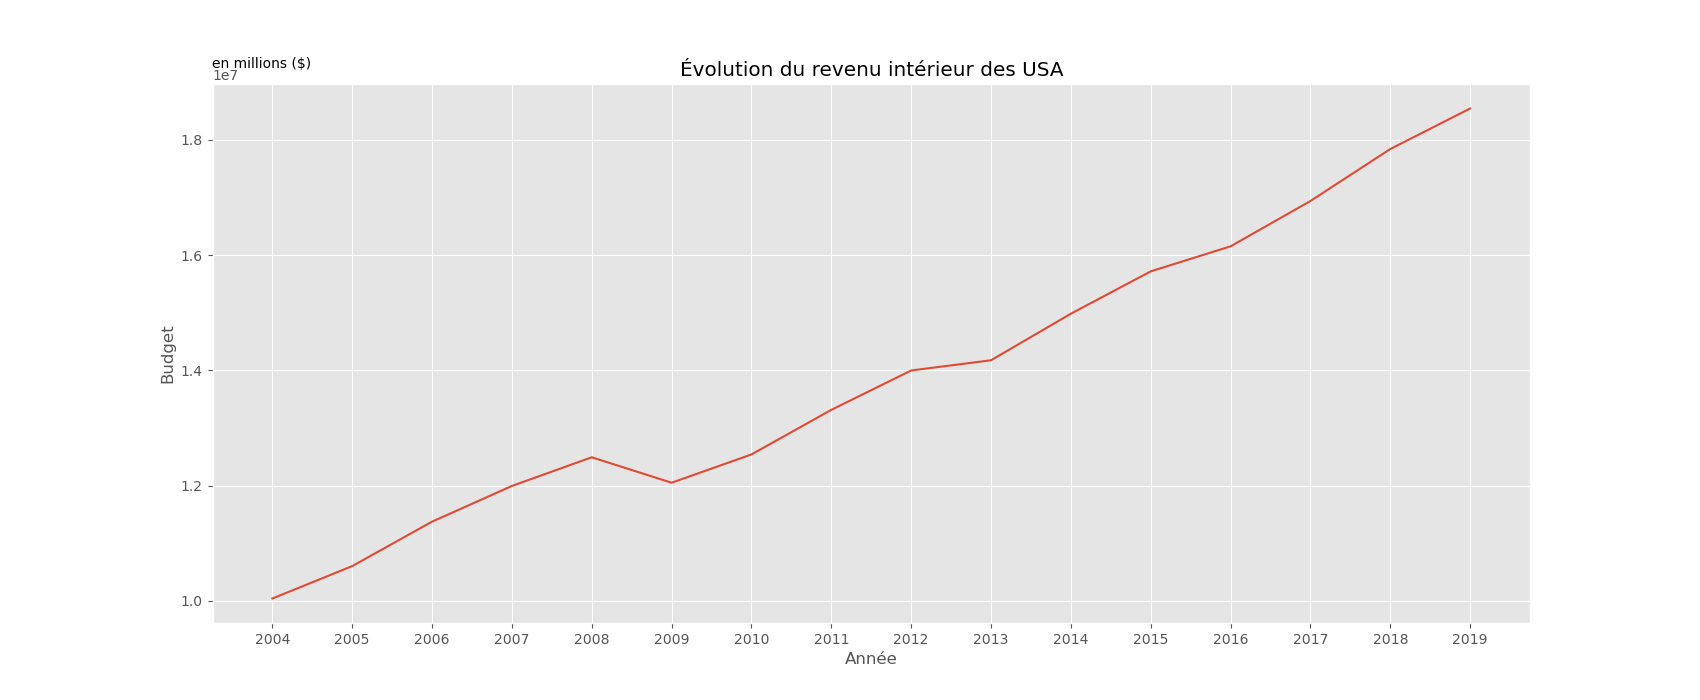

In [84]:
def formatter_1e6(x): # Pour l'affichage simplifié de l'axe Y
    return str(round(x / 1e6, 1))

tpc_total_fig, tpc_total_ax = pyplot.subplots()
tpc_total_ax.plot(numpy.array(budget_years), numpy.array(total_income_list))

# tpc_total_ax.yaxis.set_major_formatter(formatter_1e6)
tpc_total_ax.yaxis.set_minor_formatter(NullFormatter)
tpc_total_ax.set_xlabel("Année")
tpc_total_ax.set_ylabel("Budget")
tpc_total_ax.text(0, 1.05, "en millions ($)", transform=pyplot.gca().transAxes, ha="left", va="top")

tpc_total_ax.set_title("Évolution du revenu intérieur des USA")
pyplot.show()

#### Évolution du budget de la police aux USA

<IPython.core.display.Javascript object>


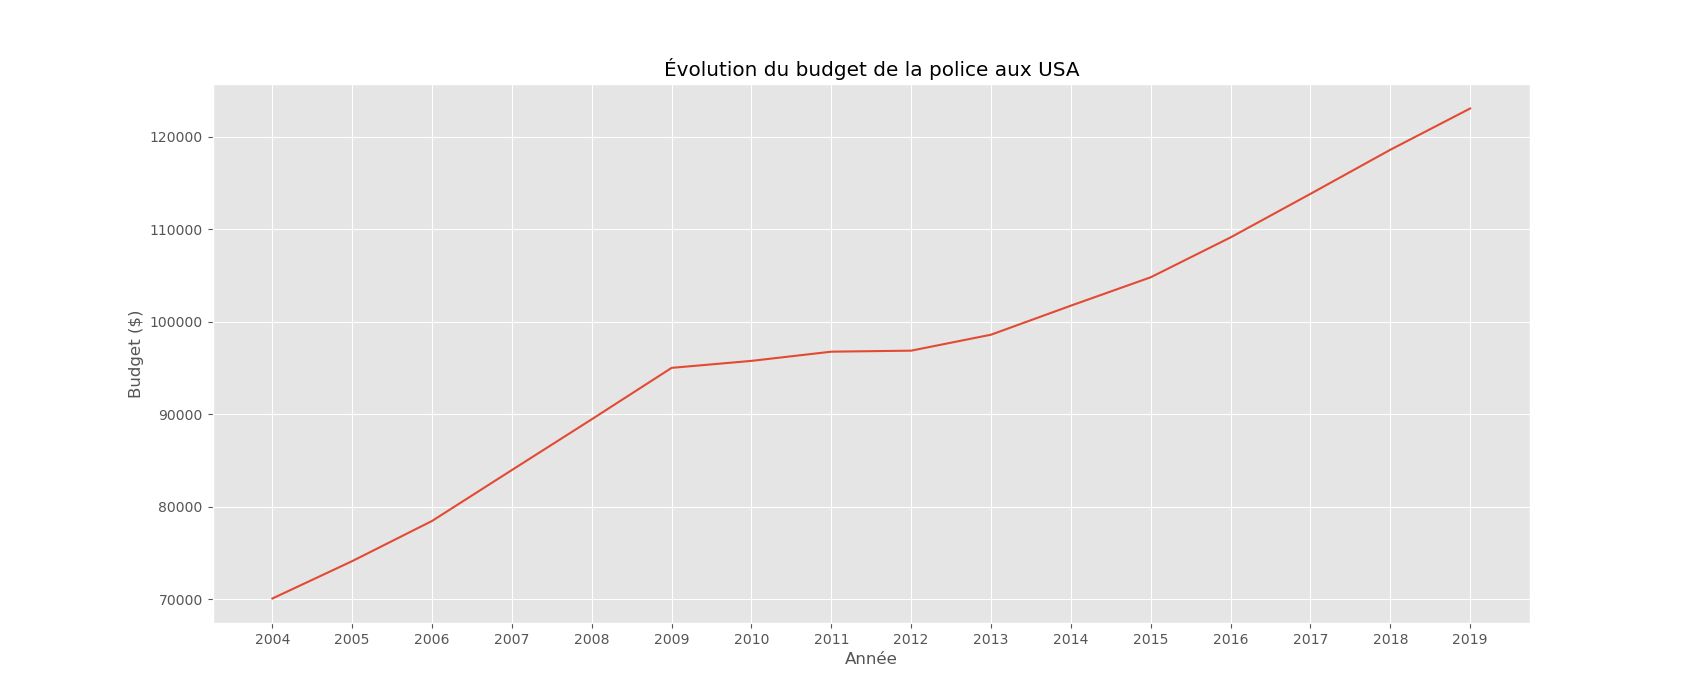

In [85]:
def formatter_1e4(x): # Pour l'affichage simplifié de l'axe Y
    return str(round(x / 1e4, 1))

tpc_police_fig, tpc_police_ax = pyplot.subplots()
tpc_police_ax.plot(numpy.array(budget_years), numpy.array(police_budget))
# tpc_police_ax.yaxis.set_major_formatter(formatter_1e4)
tpc_police_ax.yaxis.set_minor_formatter(NullFormatter)
tpc_police_ax.set_title("Évolution du budget de la police aux USA")
tpc_police_ax.set_xlabel("Année")
tpc_police_ax.set_ylabel("Budget ($)")
pyplot.show()

## Analyse géographique des données

### Carte

In [86]:
class Map:
	TILE_LAYERS = [
		{"name": "openstreetmap", "display_name": "Open Street Map"},
		{"name": "stamentoner", "display_name": "Stamen toner"},
		{"name": "cartodbpositron", "display_name": "CartoDB (Light)"},
		{"name": "cartodbdark_matter", "display_name": "CartoDB (Dark)"},
	]

	def __init__(self, crs="EPSG:3857", **kwargs):
		self.crs = crs
		self.map = folium.Map(tiles=None, crs=self.crs.replace(":", ""), **kwargs)
		self.layers = []

	def _add_tile_layers(self):
		for layer in Map.TILE_LAYERS:
			folium.TileLayer(layer["name"], name=layer["display_name"]).add_to(self.map)

	def _add_map_layers(self):
		for layer in self.layers:
			for sublayer in layer.get_layers():
				sublayer.add_to(self.map)

	def _register_layer(self, layer):
		if isinstance(layer, MapLayer):
			self.layers.append(layer)

	def fit_bounds(self, south_west, north_east):
		self.map.fit_bounds([south_west, north_east])

	def open(self, notebook=False, output_dir="./temp", filename=None):
		self._add_tile_layers()
		self._add_map_layers()
		folium.LayerControl().add_to(self.map)

		if notebook:
			return self.map

		path = os.path.join(output_dir, (filename if filename else f"map-{time.time()}.html"))

		self.map.save(path)
		webbrowser.open(path)

### Couche de carte

In [87]:
class MapLayer:
	DATA_TYPES = {"DataFrame": 0, "Geo[GCS]": 1, "TimedGeo[GCS]": 1}

	def __init__(self, name, show_default=False):
		self.name = name
		self.parent_map = None
		self.feature_group = folium.FeatureGroup(self.name, overlay=True, show=show_default)
		self.layers = []

		self.data = None
		self.data_type = False

	def get_layers(self):
		return self.layers

	def add_to(self, m):
		if isinstance(m, Map):
			self.parent_map = m
			# noinspection PyProtectedMember
			self.parent_map._register_layer(self)

		return self

	def load_dataframe(self, data):
		self.data = data
		self.data_type = MapLayer.DATA_TYPES["DataFrame"]

		return self

	def load_gcs_data(self, data, col_names=None, time_column=None):
		if time_column is None:
			col_names = col_names if col_names else {"lat": "Latitude", "lon": "Longitude"}
			data_coords = data[[col_names["lat"], col_names["lon"]]].dropna(axis=0, how="any")
			geometry = geopandas.points_from_xy(data_coords[col_names["lon"]], data_coords[col_names["lat"]])

			self.data = geopandas.GeoDataFrame(data, geometry=geometry, crs=self.parent_map.crs)
			self.data_type = MapLayer.DATA_TYPES["Geo[GCS]"]
		else:
			data_coords = data[[time_column, col_names["lat"], col_names["lon"]]].dropna(axis=0, how="any")
			data_dates = data[time_column].drop_duplicates()
			data_timed = {}

			for _, d in data_dates.iteritems():
				data_timed[d.date().__str__()] = data_coords.loc[data_coords[time_column] == d][[col_names["lat"], col_names["lon"]]].values.tolist()

			self.data = data_timed
			self.data_type = MapLayer.DATA_TYPES["TimedGeo[GCS]"]

		return self

	def _add_to_layer(self, item):
		item.add_to(self.feature_group)
		self.layers.append(item)

	def to_heatmap(self, **kwargs):
		if not self.data_type == MapLayer.DATA_TYPES["Geo[GCS]"]:
			raise RuntimeError("MapLayer: to_heatmap() is only available for GCS data.")

		heat_data = [[point.xy[1][0], point.xy[0][0]] for point in self.data.geometry if not point.is_empty]
		heat_map = folium.plugins.HeatMap(heat_data, name=self.name, **kwargs)
		self._add_to_layer(heat_map)

		return self

	def to_timed_heatmap(self, **kwargs):
		if not self.data_type == MapLayer.DATA_TYPES["TimedGeo[GCS]"]:
			raise RuntimeError("MapLayer: to_timed_heatmap() is only available for timed GCS data.")

		heat_map = folium.plugins.HeatMapWithTime(list(self.data.values()), index=list(self.data.keys()), name=self.name, **kwargs)
		self._add_to_layer(heat_map)

	def to_choropleth(self, key_on=None, fill_color=None, **kwargs):
		if not self.data_type == MapLayer.DATA_TYPES["DataFrame"]:
			raise RuntimeError("MapLayer: to_choropleth() is only available for pandas dataframes.")

		choropleth = folium.Choropleth(
			data=self.data,
			key_on=(key_on if key_on else "feature.id"),
			fill_color=(fill_color if fill_color else "YlOrRd"),
			**kwargs
		)
		self._add_to_layer(choropleth)

		return self

### Création de la carte

In [88]:
data_wp_geo = data_wp.loc[data_wp["is_geocoding_exact"]]
data_fe_geo = data_fe.loc[data_fe["Date of death"] >= datetime(2015, 1, 2)]

In [89]:
plot_map = Map()

encounter_layer = MapLayer("Fatal encounters", show_default=True)
encounter_layer.add_to(plot_map).load_gcs_data(data_fe, col_names={"lat": "Latitude", "lon": "Longitude"}, time_column="Date of death").to_timed_heatmap(
	min_opacity=0.4, radius=20
)

police_death_layer = MapLayer("Police Deaths", show_default=False)
police_death_layer.add_to(plot_map).load_dataframe(pd_state_data).to_choropleth(
	geo_data="https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json",
	columns=["State", "Number of deaths"],
	name="Police deaths",
	legend_name="Police deaths",
	key_on="feature.id",
	fill_color="YlOrRd",
	fill_opacity=0.7,
	line_opacity=0.2
)

plot_map.open(notebook=True)

In [19]:
data_fe["Year"] = pandas.DatetimeIndex(data_fe["Date of death"]).year
data_fe["Deaths"] = data_fe.groupby(["Year"])["Unique ID"].transform("count")
data_fe[["Year", "Deaths"]].drop_duplicates()

Year  Deaths
0      2000     865
865    2001     923
1788   2002     987
2775   2003    1062
3837   2004    1038
4875   2005    1170
6045   2006    1270
7315   2007    1259
8574   2008    1216
9790   2009    1262
11052  2010    1298
12350  2011    1408
13758  2012    1483
15241  2013    1778
17019  2014    1711
18730  2015    1611
20341  2016    1609
21950  2017    1772
23722  2018    1864
25586  2019    1828
27414  2020    2085
29499  2021    1998
31497  2100       0